# **Prediccion Series Diarias**




Jhon Esteban Arredondo Parra - 1035443205

Gerson Gabriel Erira - 1085931900

## **Objetivo**
Implementar modelos de Machine learning y Deep Learning para las ventas de productos masivos en 217 municipios de 5 departamentos de Colombia, con el fin de buscar el mejor modelo que aporte a la identificación de posibles preferencias de compra, tendencias de consumo y con esto proyectar un comportamiento por subcategoría de producto.

In [6]:
# pip install eralchemy #instalar libreria, si no esta disponible
#downgrade tensorflow tensorflow==2.15
# !pip install tensorflow==2.15

In [7]:
#Cargar datos de Github
import io
import requests


#Manipulacion de datos
import pandas as pd
import numpy as np
import os
from collections import Counter
# from eralchemy import render_er
# from sqlalchemy import (MetaData, Table, Column, ForeignKey)


#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split


# Gráficos
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import style
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px

#Escalar Variables
from sklearn.preprocessing import MinMaxScaler

##evitar warnings
import warnings
warnings.filterwarnings('ignore')

In [8]:
# Crear un DataFrame vacío para almacenar métricas
df_metricas = pd.DataFrame(columns=['Modelo', 'RMSE_train', 'R2_train', 'MAPE_train','RMSE_test', 'R2_test', 'MAPE_test'])

# Función para calcular métricas y almacenarlas en el DataFrame
def evaluar_modelo(nombre_modelo, modelo, X_train, y_train, X_test, y_test):
    predicciones_test = modelo.predict(X_test)
    predicciones_train = modelo.predict(X_train)

    global scaler_y
    predicciones_train = scaler_y.inverse_transform(predicciones_train.reshape(-1, 1))
    predicciones_test = scaler_y.inverse_transform(predicciones_test.reshape(-1, 1))

    # Calcular métricas test
    rmse_train = np.sqrt(mean_squared_error(y_train, predicciones_train))
    r2_train = r2_score(y_train, predicciones_train)
    mape_train = mean_absolute_percentage_error(y_train, predicciones_train)

    # Calcular métricas test
    rmse_test = np.sqrt(mean_squared_error(y_test, predicciones_test))
    r2_test = r2_score(y_test, predicciones_test)
    mape_test = mean_absolute_percentage_error(y_test, predicciones_test)

    # Agregar resultados al DataFrame
    global df_metricas
    df_metricas = pd.concat([df_metricas, pd.DataFrame({'Modelo': [nombre_modelo],
                                                        'RMSE_train': [rmse_train], 'R2_train': [r2_train], 'MAPE_train': [mape_train],
                                                        'RMSE_test': [rmse_test], 'R2_test': [r2_test], 'MAPE_test': [mape_test],
                                                        })], ignore_index=True)


# 1. Cargar Datos

In [9]:
df_rellenado = pd.read_csv('datosPorDiaDepartamento_ceros.csv')
df_interpolado = pd.read_csv('datosPorDiaDepartamento_interpolado.csv')

In [10]:
df_rellenado['FECHA'] = pd.to_datetime(df_rellenado['FECHA'])
#quitar ultimo trimestre
df_rellenado = df_rellenado[df_rellenado['FECHA'] < '2022-10-01']
df_rellenado['FECHA'].max()

Timestamp('2022-09-30 00:00:00')

# 2. Serie llenada con ceros

## 2.1. Analisis Exploratorio de Datos (EDA)

In [11]:
df_rellenado.columns

Index(['FECHA', 'mes', 'dia_num', 'subcategory', 'Dia', 'Tipo Dia', 'Dpto',
       'CANTIDAD',
       'Cuarta medida correctiva al Código Nacional de Policía más impuesta en  la entidad territorial',
       'Fallecidos por siniestros viales', 'Porcentaje población de hombres',
       'Porcentaje población de mujeres',
       'Primera medida correctiva al Código Nacional de Policía más impuesta en  la entidad territorial',
       'Proporción en que son impuestas otras medidas correctivas al Código Nacional de Policía más impuesta en  la entidad territorial',
       'Puntaje SISBEN: Promedio - Cabecera',
       'Quinta medida correctiva al Código Nacional de Policía más impuesta en  la entidad territorial',
       'Segunda medida correctiva al Código Nacional de Policía más impuesta en  la entidad territorial',
       'Tasa de exámenes médico legales por presunto delito sexual contra niños y niñas de 0 a 5 años',
       'Tasa de extorsión por cada 100.000 habitantes',
       'Tasa de hom

### Variables Numericas

In [12]:
fig = px.box(df_rellenado, y='CANTIDAD', hover_data=["subcategory"],
             title='Distribución de las Cantidades',
             color_discrete_sequence=px.colors.qualitative.Dark2_r)
fig.show()

In [13]:
##para una mejor visualización, a continuacion acortamos las columnas con demasiados caracteres
new_column_names = {col: col.replace("en  la entidad territorial", "") for col in df_rellenado.columns}
df_rellenado.rename(columns=new_column_names, inplace=True)

In [14]:
df_rellenado.select_dtypes(include=['float', 'int']).columns[3:]


Index(['Cuarta medida correctiva al Código Nacional de Policía más impuesta ',
       'Fallecidos por siniestros viales', 'Porcentaje población de hombres',
       'Porcentaje población de mujeres',
       'Primera medida correctiva al Código Nacional de Policía más impuesta ',
       'Proporción en que son impuestas otras medidas correctivas al Código Nacional de Policía más impuesta ',
       'Puntaje SISBEN: Promedio - Cabecera',
       'Quinta medida correctiva al Código Nacional de Policía más impuesta ',
       'Segunda medida correctiva al Código Nacional de Policía más impuesta ',
       'Tasa de exámenes médico legales por presunto delito sexual contra niños y niñas de 0 a 5 años',
       'Tasa de extorsión por cada 100.000 habitantes',
       'Tasa de homicidio intencional en hombres por cada 100.000 habitantes',
       'Tasa de homicidios en accidentes de tránsito por cada 100.000 habitantes',
       'Tasa de hurto a personas por cada 100.000 habitantes',
       'Tasa de les

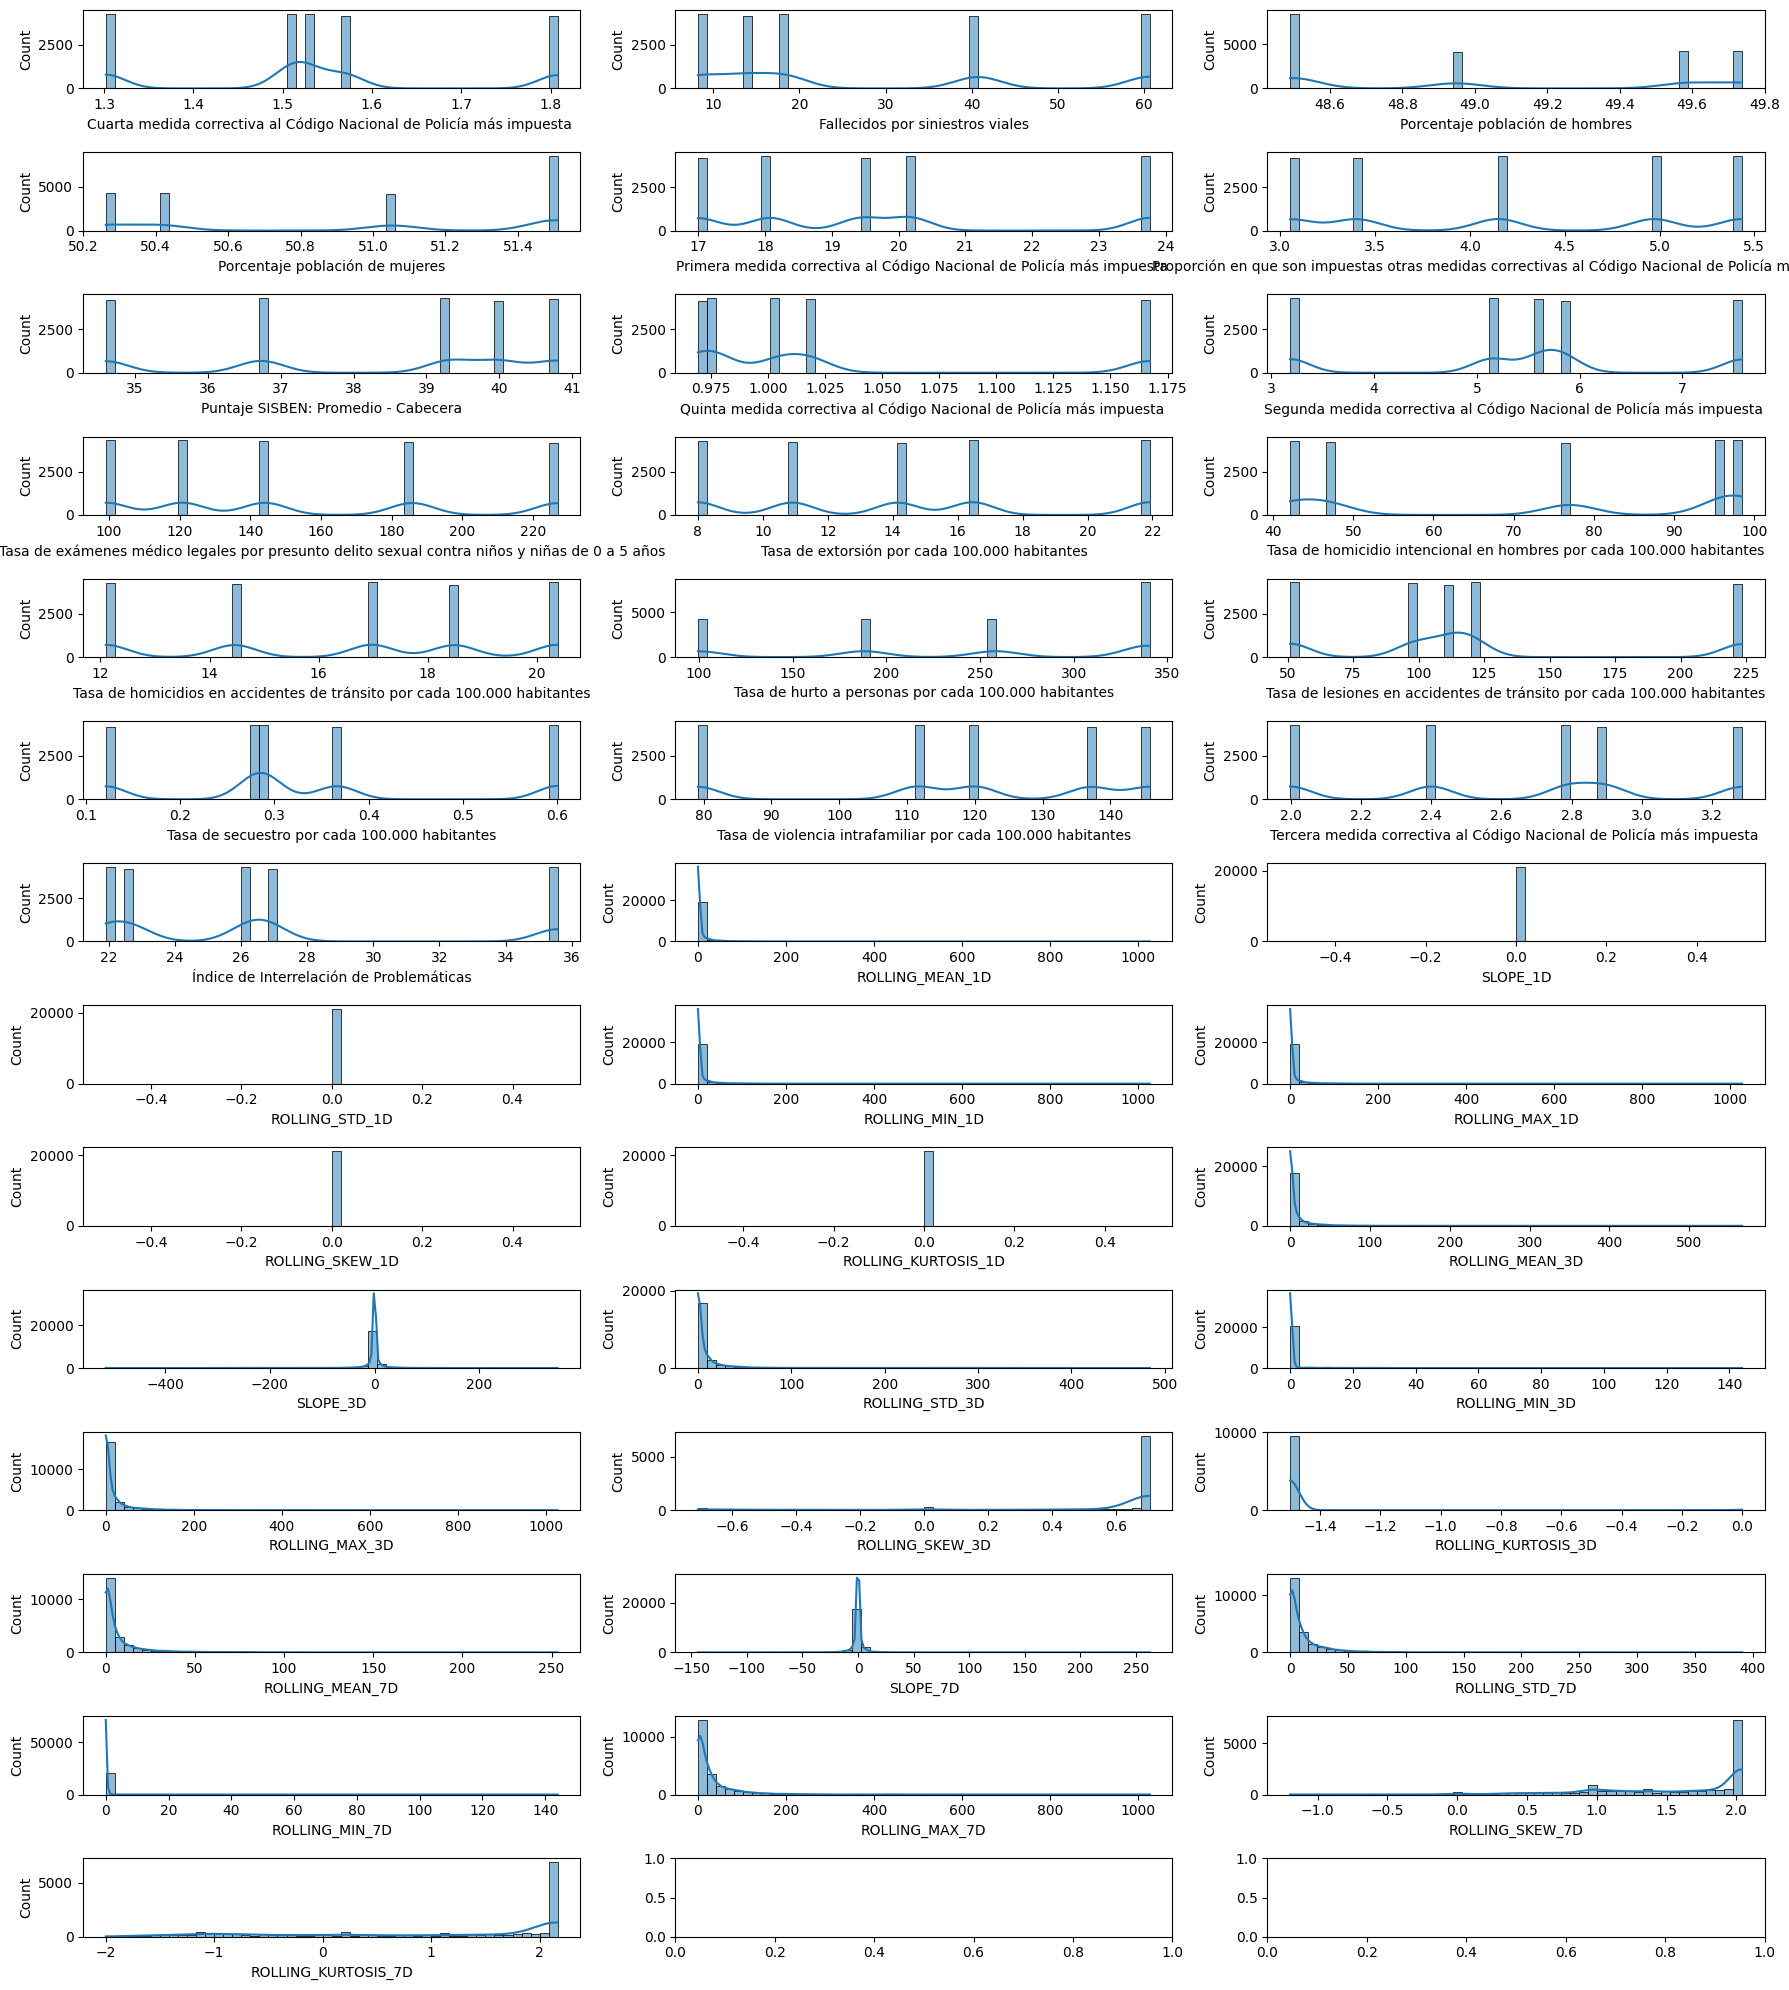

In [15]:
##distribucion de variables cuantitativas
columns_to_plot = df_rellenado.select_dtypes(include=['float', 'int']).columns[3:]

# Crear un grid de gráficos
fig, axes = plt.subplots(14, 3, figsize=(18, 20))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    sns.histplot(df_rellenado[col], ax=axes[i], kde=True, bins=50)
    # axes[i].set_title(f'Distribución de {col}')

plt.tight_layout()
plt.show()


In [16]:
#plot matriz de correlación
corr = df_rellenado.select_dtypes(include=['float', 'int']).corr()
corr.style.background_gradient(cmap='coolwarm')

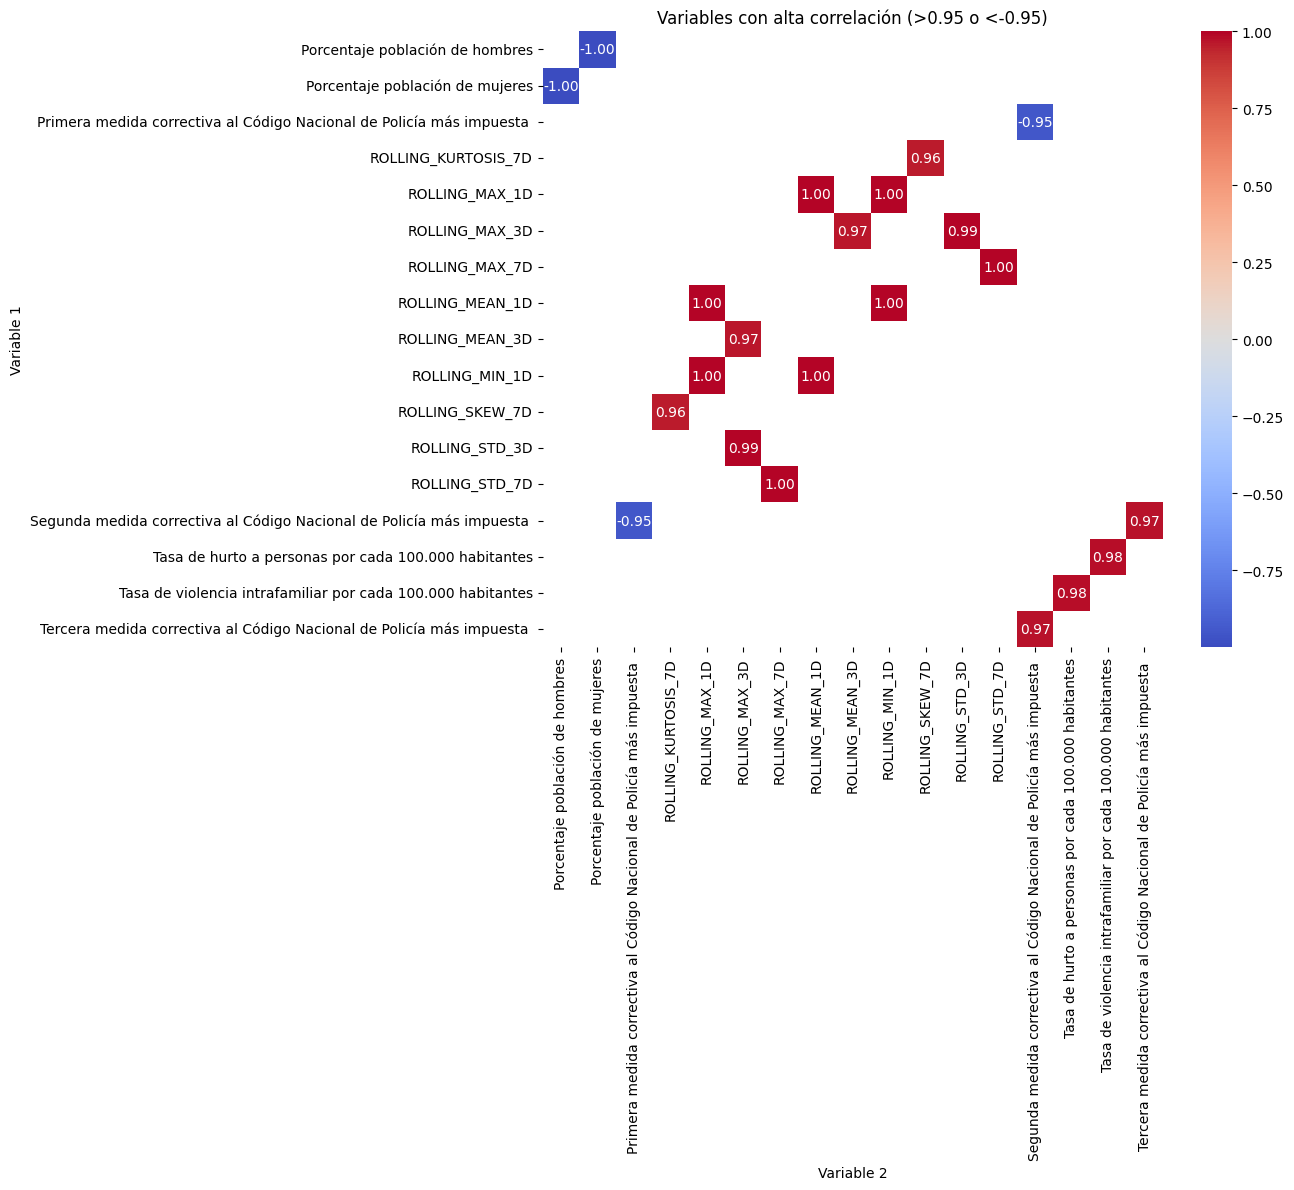

In [17]:
# prompt: graficar las relaciones mayores a 0.95 o menores a -0.95, excluyendo las que son contra la misma variable

# Filtrar correlaciones mayores a 0.95 o menores a -0.95 y que no sean la diagonal principal
high_corr = corr[(corr > 0.95) | (corr < -0.95)]
high_corr = high_corr.stack().reset_index()
high_corr = high_corr[high_corr['level_0'] != high_corr['level_1']]
high_corr.columns = ['Variable 1', 'Variable 2', 'Correlacion']

# Graficar las relaciones filtradas
plt.figure(figsize=(10, 8))
sns.heatmap(high_corr.pivot(index='Variable 1', columns='Variable 2', values='Correlacion'), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Variables con alta correlación (>0.95 o <-0.95)')
plt.show()


In [18]:
##correlacion de pearson
corr = df_rellenado.select_dtypes(include=['float', 'int']).corr()
corr["CANTIDAD"].sort_values(ascending=False)

CANTIDAD                                                                                                 1.000000
ROLLING_MEAN_7D                                                                                          0.299691
ROLLING_STD_7D                                                                                           0.241776
ROLLING_MAX_7D                                                                                           0.240702
Primera medida correctiva al Código Nacional de Policía más impuesta                                     0.216675
ROLLING_MEAN_3D                                                                                          0.216193
ROLLING_MEAN_1D                                                                                          0.213450
ROLLING_MIN_1D                                                                                           0.213450
ROLLING_MAX_1D                                                                                           0.213450
Tasa de homicidio intencional en hombres por cada 100.000 habitantes                                     0.197641
ROLLING_MAX_3D                                                                                           0.197209
ROLLING_STD_3D                                                                                           0.184955
Tasa de extorsión por cada 100.000 habitantes                                                            0.174808
Proporción en que son impuestas otras medidas correctivas al Código Nacional de Policía más impuesta     0.168971
Índice de Interrelación de Problemáticas                                                                 0.135955
ROLLING_MIN_3D                                                                                           0.128148
Tasa de secuestro por cada 100.000 habitantes                                                            0.116437
Tasa de homicidios en accidentes de tránsito por cada 100.000 habitantes                                 0.113984
SLOPE_3D                                                                                                 0.100564
Fallecidos por siniestros viales                                                                         0.074432
Porcentaje población de hombres                                                                          0.071645
ROLLING_MIN_7D                                                                                           0.054384
ROLLING_KURTOSIS_3D                                                                                      0.007878
dia_num                                                                                                  0.002773
Puntaje SISBEN: Promedio - Cabecera                                                                     -0.000022
mes                                                                                                     -0.012853
SLOPE_7D                                                                                                -0.024446
Tasa de violencia intrafamiliar por cada 100.000 habitantes                                             -0.050283
Porcentaje población de mujeres                                                                         -0.071650
ROLLING_SKEW_3D                                                                                         -0.078864
Tasa de hurto a personas por cada 100.000 habitantes                                                    -0.079044
Quinta medida correctiva al Código Nacional de Policía más impuesta                                     -0.091045
Tasa de lesiones en accidentes de tránsito por cada 100.000 habitantes                                  -0.148776
ROLLING_KURTOSIS_7D                                                                                     -0.154702
ROLLING_SKEW_7D                                                                                         -0.169764
Tasa de ex

In [19]:
##correlacion de spearman
corr = df_rellenado.select_dtypes(include=['float', 'int']).corr(method='spearman')
corr["CANTIDAD"].sort_values(ascending=False)

CANTIDAD                                                                                                 1.000000
ROLLING_MEAN_7D                                                                                          0.338438
ROLLING_MAX_7D                                                                                           0.322966
ROLLING_STD_7D                                                                                           0.321964
Primera medida correctiva al Código Nacional de Policía más impuesta                                     0.262139
ROLLING_MEAN_1D                                                                                          0.246675
ROLLING_MIN_1D                                                                                           0.246675
ROLLING_MAX_1D                                                                                           0.246675
Proporción en que son impuestas otras medidas correctivas al Código Nacional de Policía más impuesta     0.229226
Tasa de homicidio intencional en hombres por cada 100.000 habitantes                                     0.226977
Tasa de extorsión por cada 100.000 habitantes                                                            0.226977
ROLLING_MEAN_3D                                                                                          0.224883
ROLLING_MAX_3D                                                                                           0.223045
ROLLING_STD_3D                                                                                           0.218654
Tasa de secuestro por cada 100.000 habitantes                                                            0.160571
Fallecidos por siniestros viales                                                                         0.137802
SLOPE_3D                                                                                                 0.123701
Tasa de homicidios en accidentes de tránsito por cada 100.000 habitantes                                 0.119622
ROLLING_MIN_3D                                                                                           0.115273
Porcentaje población de hombres                                                                          0.056266
Índice de Interrelación de Problemáticas                                                                 0.052319
ROLLING_MIN_7D                                                                                           0.041774
dia_num                                                                                                  0.011619
mes                                                                                                     -0.000282
ROLLING_KURTOSIS_3D                                                                                     -0.026860
Quinta medida correctiva al Código Nacional de Policía más impuesta                                     -0.046666
Porcentaje población de mujeres                                                                         -0.056266
Puntaje SISBEN: Promedio - Cabecera                                                                     -0.060502
SLOPE_7D                                                                                                -0.076809
ROLLING_SKEW_3D                                                                                         -0.104973
Tasa de violencia intrafamiliar por cada 100.000 habitantes                                             -0.133135
Tasa de lesiones en accidentes de tránsito por cada 100.000 habitantes                                  -0.133566
Tasa de hurto a personas por cada 100.000 habitantes                                                    -0.142513
ROLLING_KURTOSIS_7D                                                                                     -0.209060
ROLLING_SKEW_7D                                                                                         -0.220160
Tasa de ex

### Variables Categoricas

In [20]:
df_rellenado.select_dtypes(include=['object']).describe()

subcategory      Dia Tipo Dia             Dpto
count        21204    21204    21204            21204
unique          16        7        4                5
top      Pasabocas  Viernes  Laboral  VALLE DEL CAUCA
freq          1351     6413    15601             4299

Inicialmente teniamos una lista de 3829 productos distintos, sin embargo, por su alta diversidad se utilizará para efectos del trabajo con la subcategoria asociada, las cuales son 16 clases distintas. Ya el dataset está agregado a nivel de subcategoria

Caso similar sucede con los municipios, donde son 217 pero se trabajara con el departamento al que pertenecen

Por ende, las columnas PRODUCTO, Subregion y Municipio no harán parte del dataset final que se usará para entrenar modelos de regresión

In [21]:
df_rellenado["subcategory"].value_counts()

subcategory
Pasabocas                         1351
Frutas y Verduras                 1351
Despensa                          1344
Productos Congelados              1340
Dulces y postres                  1339
Cuidado Personal                  1339
Limpieza de cocina                1336
Panadería y Pastelería            1333
Lácteos, huevos y refrigerados    1332
Bebidas                           1327
Vinos y Licores                   1326
Utiles Escolares                  1321
Charcutería                       1317
Aseo de hogar                     1312
Belleza                           1273
Cuidado de ropa y calzado         1263
Name: count, dtype: int64

In [22]:
df_rellenado.pivot_table(index="subcategory", columns="mes", values="CANTIDAD", aggfunc="sum")

mes                                  1       2       3       4       5  \
subcategory                                                              
Aseo de hogar                    172.0   160.0   183.0   160.0   105.0   
Bebidas                          231.0   177.0   362.0   191.0   295.0   
Belleza                           61.0    55.0    38.0    52.0    40.0   
Charcutería                      315.0   193.0   161.0   150.0   259.0   
Cuidado Personal                 892.0  1514.0  1463.0  1216.0   919.0   
Cuidado de ropa y calzado         85.0   142.0   110.0    97.0    94.0   
Despensa                        1973.0  1908.0  2068.0  1305.0  1264.0   
Dulces y postres                 942.0  1205.0  1579.0  1242.0  1226.0   
Frutas y Verduras               3766.0  3278.0  3868.0  3660.0  3646.0   
Limpieza de cocina               628.0   697.0   577.0   663.0   308.0   
Lácteos, huevos y refrigerados   626.0   718.0   889.0   849.0   862.0   
Panadería y Pastelería             0.0     0.0     0.0     0.0     0.0   
Pasabocas                       2283.0  1628.0  2166.0  2064.0  2124.0   
Productos Congelados             182.0   184.0   442.0   260.0   213.0   
Utiles Escolares                 486.0   302.0   327.0   295.0   208.0   
Vinos y Licores                   75.0    78.0   100.0    44.0    74.0   

mes                                  6       7       8       9  
subcategory                                                     
Aseo de hogar                    137.0   103.0   186.0   193.0  
Bebidas                          211.0   151.0   348.0   411.0  
Belleza                           24.0    40.0    50.0    54.0  
Charcutería                      299.0   249.0   328.0   319.0  
Cuidado Personal                 808.0   336.0   600.0   553.0  
Cuidado de ropa y calzado         73.0    36.0   100.0    94.0  
Despensa                        1204.0   979.0  1412.0  1148.0  
Dulces y postres                 819.0   844.0   998.0  1122.0  
Frutas y Verduras               3793.0  2499.0  3858.0  3228.0  
Limpieza de cocina               798.0   336.0   323.0   323.0  
Lácteos, huevos y refrigerados   756.0   640.0   715.0   777.0  
Panadería y Pastelería             0.0     0.0     0.0     0.0  
Pasabocas                       1873.0  1928.0  2033.0  1928.0  
Productos Congelados             227.0   250.0   291.0   161.0  
Utiles Escolares                 277.0   256.0   454.0   397.0  
Vinos y Licores                   88.0    69.0    72.0    95.0

In [23]:
df_rellenado.pivot_table(index="Dpto", columns="mes", values="CANTIDAD", aggfunc="sum")

mes                   1       2       3       4       5       6       7  \
Dpto                                                                      
ANTIOQUIA        6148.0  5718.0  7604.0  6274.0  5189.0  5473.0  4270.0   
CALDAS           1127.0  1217.0   987.0   751.0   992.0   941.0   632.0   
QUINDÍO           274.0   259.0   299.0   237.0   185.0   198.0   246.0   
RISARALDA         660.0   571.0   626.0   482.0   560.0   559.0   350.0   
VALLE DEL CAUCA  4508.0  4474.0  4817.0  4504.0  4711.0  4216.0  3218.0   

mes                   8       9  
Dpto                             
ANTIOQUIA        5469.0  5570.0  
CALDAS            945.0   900.0  
QUINDÍO           355.0   206.0  
RISARALDA         537.0   483.0  
VALLE DEL CAUCA  4462.0  3644.0

In [24]:
import plotly.express as px

# Crear el box plot usando Plotly
fig = px.box(df_rellenado,
             x='Dpto',
             y='CANTIDAD',
             color='Dpto',
             title='Distribución de la Subregión vs. Cantidades',
             color_discrete_sequence=px.colors.qualitative.Safe,
             hover_data=["subcategory", "mes"])


# Personalizar el gráfico
fig.update_layout(
    xaxis_title='dp_pruebas_rellenadoto',
    yaxis_title='CANTIDAD',
    title={
        'text': 'Distribución de la Subregión vs. Cantidades',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 14, 'family': 'Arial', 'color': 'black'},
    }
)

# Rotar las etiquetas del eje x
fig.update_xaxes(tickangle=90)

fig.show()


In [25]:
# Crear el box plot usando Plotly
fig = px.box(df_rellenado,
             x='subcategory',
             y='CANTIDAD',
             color='subcategory',
             title='Distribución de la subcategoria vs. Cantidades',
             color_discrete_sequence=px.colors.qualitative.Bold,
             hover_data=["Dpto", "mes"])


# Personalizar el gráfico
fig.update_layout(
    xaxis_title='subcategory',
    yaxis_title='CANTIDAD',
    title={
        'text': 'Distribución de la subcategoria vs. Cantidades',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top',
        'font': {'size': 14, 'family': 'Arial', 'color': 'black'},
    }
)

# Rotar las etiquetas del eje x
fig.update_xaxes(tickangle=90)

fig.show()

## 2.2. Datos de Prueba

In [26]:
##para el modelo no requerimos de los campos FECHA, UNIDAD, municipio, departamento y total por las razones mencionadas a lo largo del analisis
df_rellenado = df_rellenado[['subcategory',
        'Dpto',
       'CANTIDAD',
       'ROLLING_MEAN_1D', 'ROLLING_MEAN_3D', 'ROLLING_MEAN_7D',
       'SLOPE_3D', 'SLOPE_7D',
       'ROLLING_STD_3D', 'ROLLING_STD_7D',
       'ROLLING_MIN_3D', 'ROLLING_MIN_7D',
       'ROLLING_MAX_3D', 'ROLLING_MAX_7D',
       'ROLLING_SKEW_3D',
         'ROLLING_SKEW_7D',
       'ROLLING_KURTOSIS_3D',
        #  'ROLLING_KURTOSIS_7D',
       'Cuarta medida correctiva al Código Nacional de Policía más impuesta ',
       'Fallecidos por siniestros viales', 'Porcentaje población de hombres',
       'Porcentaje población de mujeres',
       'Primera medida correctiva al Código Nacional de Policía más impuesta ',
       'Proporción en que son impuestas otras medidas correctivas al Código Nacional de Policía más impuesta ',
       'Puntaje SISBEN: Promedio - Cabecera',
       'Quinta medida correctiva al Código Nacional de Policía más impuesta ',
      #  'Segunda medida correctiva al Código Nacional de Policía más impuesta ',
       'Tasa de exámenes médico legales por presunto delito sexual contra niños y niñas de 0 a 5 años',
       'Tasa de extorsión por cada 100.000 habitantes',
       'Tasa de homicidio intencional en hombres por cada 100.000 habitantes',
       'Tasa de homicidios en accidentes de tránsito por cada 100.000 habitantes',
       'Tasa de hurto a personas por cada 100.000 habitantes',
       'Tasa de lesiones en accidentes de tránsito por cada 100.000 habitantes',
       'Tasa de secuestro por cada 100.000 habitantes',
       'Tasa de violencia intrafamiliar por cada 100.000 habitantes',
      #  'Tercera medida correctiva al Código Nacional de Policía más impuesta ',
       'Índice de Interrelación de Problemáticas',
        'FECHA' ##dejamos la FECHA para identificar la correcta separación en train and test. pero no será parte de los modelos.
         ]]

df_rellenado['FECHA'] = pd.to_datetime(df_rellenado['FECHA'])
df_rellenado = df_rellenado.sort_values(by="FECHA", ascending=True).reset_index(drop=True)

In [27]:
df_rellenado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21204 entries, 0 to 21203
Data columns (total 35 columns):
 #   Column                                                                                                 Non-Null Count  Dtype         
---  ------                                                                                                 --------------  -----         
 0   subcategory                                                                                            21204 non-null  object        
 1   Dpto                                                                                                   21204 non-null  object        
 2   CANTIDAD                                                                                               21204 non-null  float64       
 3   ROLLING_MEAN_1D                                                                                        21124 non-null  float64       
 4   ROLLING_MEAN_3D                                     

In [28]:
df_rellenado.shape

(21204, 35)

In [29]:
# Porcentaje de filas para la primera parte (train y test)
percentage_first_part = 0.90

# Número de filas para la primera parte
n_rows_part1 = int(len(df_rellenado) * percentage_first_part)

##obtenemos la fecha de corte, donde se aproxima el 90% de nuestros datos
fecha_corte = df_rellenado.loc[n_rows_part1, 'FECHA']

# Dividir el DataFrame en dos partes, a partir de la fecha de corte
df_prep_rellenado = df_rellenado.loc[df_rellenado['FECHA']<=fecha_corte]
dp_pruebas_rellenado = df_rellenado.loc[df_rellenado['FECHA']>fecha_corte]

In [30]:
df_prep_rellenado.FECHA.max(), dp_pruebas_rellenado.FECHA.min()

(Timestamp('2022-09-03 00:00:00'), Timestamp('2022-09-04 00:00:00'))

In [31]:
print(df_prep_rellenado.shape)
print(dp_pruebas_rellenado.shape)

(19115, 35)
(2089, 35)


In [32]:
19115 + 2089

21204

In [33]:
##exportar d_prep y dp_pruebas_rellenado
df_prep_rellenado.to_csv('df_prep_rellenado.csv', index=False)
dp_pruebas_rellenado.to_csv('df_pruebas_rellenado.csv', index=False)

In [37]:
df_prep_rellenado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19115 entries, 0 to 19114
Data columns (total 35 columns):
 #   Column                                                                                                 Non-Null Count  Dtype         
---  ------                                                                                                 --------------  -----         
 0   subcategory                                                                                            19115 non-null  object        
 1   Dpto                                                                                                   19115 non-null  object        
 2   CANTIDAD                                                                                               19115 non-null  float64       
 3   ROLLING_MEAN_1D                                                                                        19035 non-null  float64       
 4   ROLLING_MEAN_3D                                          

## 2.3. Preparar Datos para Modelos ML

In [35]:
# resprep = requests.get('https://github.com/Gabriel93UdeA/AprendizajeAutomatico/raw/main/df_prep_seminario.csv')
# resprep.raise_for_status()
# df_modelo = pd.read_csv(io.BytesIO(resprep.content))

df_modelo = df_prep_rellenado.copy(deep=True)
df_modelo.dropna(inplace=True)
df_modelo.reset_index(drop=True, inplace=True)

df_modelo.shape

(8865, 35)

In [ ]:
df_modelo.sample()

subcategory             Dpto  CANTIDAD  ROLLING_MEAN_1D  \
3645  Frutas y Verduras  VALLE DEL CAUCA       0.0             45.0   

      ROLLING_MEAN_3D  ROLLING_MEAN_7D  SLOPE_3D  SLOPE_7D  ROLLING_STD_3D  \
3645             17.0        38.142857      22.5 -3.892857       19.949937   

      ROLLING_STD_7D  ...  \
3645       39.879922  ...   

      Tasa de exámenes médico legales por presunto delito sexual contra niños y niñas de 0 a 5 años  \
3645                                          99.077249                                               

      Tasa de extorsión por cada 100.000 habitantes  \
3645                                      21.920305   

      Tasa de homicidio intencional en hombres por cada 100.000 habitantes  \
3645                                          98.490873                      

      Tasa de homicidios en accidentes de tránsito por cada 100.000 habitantes  \
3645                                          20.384819                          

      Tasa de hurto a personas por cada 100.000 habitantes  \
3645                                         258.347764      

      Tasa de lesiones en accidentes de tránsito por cada 100.000 habitantes  \
3645                                         119.983867                        

      Tasa de secuestro por cada 100.000 habitantes  \
3645                                       0.600716   

      Tasa de violencia intrafamiliar por cada 100.000 habitantes  \
3645                                          120.06324             

      Índice de Interrelación de Problemáticas      FECHA  
3645                                 21.899319 2022-04-05  

[1 rows x 35 columns]

### Dummies

In [ ]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8865 entries, 0 to 8864
Data columns (total 35 columns):
 #   Column                                                                                                 Non-Null Count  Dtype         
---  ------                                                                                                 --------------  -----         
 0   subcategory                                                                                            8865 non-null   object        
 1   Dpto                                                                                                   8865 non-null   object        
 2   CANTIDAD                                                                                               8865 non-null   float64       
 3   ROLLING_MEAN_1D                                                                                        8865 non-null   float64       
 4   ROLLING_MEAN_3D                                       

In [ ]:
## Generar columnas Dummy
df_modelo = pd.get_dummies(df_modelo, drop_first=1)

# Convertir todas las columnas booleanas a enteros
for col in df_modelo.select_dtypes(include='bool').columns:
    df_modelo[col] = df_modelo[col].astype(int)

df_modelo.sample()

CANTIDAD  ROLLING_MEAN_1D  ROLLING_MEAN_3D  ROLLING_MEAN_7D  SLOPE_3D  \
2433       0.0              0.0        18.333333        10.714286       0.0   

      SLOPE_7D  ROLLING_STD_3D  ROLLING_STD_7D  ROLLING_MIN_3D  \
2433  3.928571       25.927249       19.351739             0.0   

      ROLLING_MIN_7D  ...  subcategory_Lácteos, huevos y refrigerados  \
2433             0.0  ...                                           0   

      subcategory_Panadería y Pastelería  subcategory_Pasabocas  \
2433                                   0                      0   

      subcategory_Productos Congelados  subcategory_Utiles Escolares  \
2433                                 0                             0   

      subcategory_Vinos y Licores  Dpto_CALDAS  Dpto_QUINDÍO  Dpto_RISARALDA  \
2433                            0            0             1               0   

      Dpto_VALLE DEL CAUCA  
2433                     0  

[1 rows x 52 columns]

In [ ]:
df_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8865 entries, 0 to 8864
Data columns (total 52 columns):
 #   Column                                                                                                 Non-Null Count  Dtype         
---  ------                                                                                                 --------------  -----         
 0   CANTIDAD                                                                                               8865 non-null   float64       
 1   ROLLING_MEAN_1D                                                                                        8865 non-null   float64       
 2   ROLLING_MEAN_3D                                                                                        8865 non-null   float64       
 3   ROLLING_MEAN_7D                                                                                        8865 non-null   float64       
 4   SLOPE_3D                                              

### Train and Test

In [ ]:
X = df_modelo.drop(columns = ["CANTIDAD"])
y = df_modelo['CANTIDAD']

In [ ]:
##realizar un TimeSeriesSplit
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

TRAIN: [   0    1    2 ... 2214 2215 2216] TEST: [2217 2218 2219 ... 4430 4431 4432]
TRAIN: [   0    1    2 ... 4430 4431 4432] TEST: [4433 4434 4435 ... 6646 6647 6648]
TRAIN: [   0    1    2 ... 6646 6647 6648] TEST: [6649 6650 6651 ... 8862 8863 8864]


In [ ]:
print(X_train.shape) #(6649, 51)
print(X_test.shape) #(2216, 51)
print(y_train.shape) #(2216,)
print(y_test.shape) #(2216, )

(6649, 51)
(2216, 51)
(6649,)
(2216,)


In [ ]:
8004 + 2667

10671

In [ ]:
X_train.drop(columns=["FECHA"], inplace=True)
X_test.drop(columns=["FECHA"], inplace=True)

### Escalar Variables

In [ ]:
num_vars = X_train.select_dtypes(include=['float', 'int']).columns.tolist()

In [ ]:
# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

X_train[num_vars].sample(2)

ROLLING_MEAN_1D  ROLLING_MEAN_3D  ROLLING_MEAN_7D  SLOPE_3D  SLOPE_7D  \
3397              0.0         0.011786         0.046249  0.598692  0.348796   
4359              0.0         0.007071         0.006768  0.608799  0.356264   

      ROLLING_STD_3D  ROLLING_STD_7D  ROLLING_MIN_3D  ROLLING_MIN_7D  \
3397        0.019006        0.037482             0.0             0.0   
4359        0.008655        0.008912             0.0             0.0   

      ROLLING_MAX_3D  ...  subcategory_Lácteos, huevos y refrigerados  \
3397        0.018519  ...                                         0.0   
4359        0.008772  ...                                         1.0   

      subcategory_Panadería y Pastelería  subcategory_Pasabocas  \
3397                                 0.0                    1.0   
4359                                 0.0                    0.0   

      subcategory_Productos Congelados  subcategory_Utiles Escolares  \
3397                               0.0                           0.0   
4359                               0.0                           0.0   

      subcategory_Vinos y Licores  Dpto_CALDAS  Dpto_QUINDÍO  Dpto_RISARALDA  \
3397                          0.0          0.0           1.0             0.0   
4359                          0.0          0.0           1.0             0.0   

      Dpto_VALLE DEL CAUCA  
3397                   0.0  
4359                   0.0  

[2 rows x 50 columns]

In [ ]:
##escalar y
from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

# scaler_y = StandardScaler()
# y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
# y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

## 2.4. Modelos de Machine Learning

In [ ]:
##Modelos Base
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet

#Evaluación del modelo
import sklearn.metrics as metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

#optimizar modelos
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

### SVM

In [ ]:
SVMR_linear    = SVR(kernel='linear' , C = 10)
SVMR_Pol2   = SVR(kernel='poly'   , C = 10, degree = 2)
SVMR_Pol3   = SVR(kernel='poly'   , C = 10, degree = 3)
SVMR_rbf   = SVR(kernel='rbf'    , C = 10)


SVMR_linear.fit(X_train, y_train)
SVMR_Pol2.fit(X_train, y_train)
SVMR_Pol3.fit(X_train, y_train)
SVMR_rbf.fit(X_train, y_train)


SVR(C=10)

In [ ]:
##R2 score
print('Linear   Training: ', SVMR_linear.score(X_train,y_train), 'Test:', r2_score(y_test,SVMR_linear.predict(X_test)))
print('Poly 2   Training: ', SVMR_Pol2.score(X_train,y_train), 'Test:', r2_score(y_test,SVMR_Pol2.predict(X_test)))
print('Poly 3   Training: ', SVMR_Pol3.score(X_train,y_train), 'Test:', r2_score(y_test,SVMR_Pol3.predict(X_test)))
print('rbf      Training: ', SVMR_rbf.score(X_train,y_train), 'Test:', r2_score(y_test,SVMR_rbf.predict(X_test)))


Linear   Training:  -1.3770992133846218 Test: -2.0678755411188496
Poly 2   Training:  -0.1035256639686799 Test: -0.38854102089233233
Poly 3   Training:  -0.15837575340725385 Test: -0.4843452732823508
rbf      Training:  -0.5408569009343485 Test: -0.9929329555301889


In [ ]:
#RMSE
print('Linear  Training: ', np.sqrt(mean_squared_error(y_train,SVMR_linear.predict(X_train))),
      'Test:', np.sqrt(mean_squared_error(y_test,SVMR_linear.predict(X_test))))
print('Poly 2  Training: ', np.sqrt(mean_squared_error(y_train,SVMR_Pol2.predict(X_train))),
      'Test:', np.sqrt(mean_squared_error(y_test,SVMR_Pol2.predict(X_test))))
print('Poly 3  Training: ', np.sqrt(mean_squared_error(y_train,SVMR_Pol3.predict(X_train))),
      'Test:', np.sqrt(mean_squared_error(y_test,SVMR_Pol3.predict(X_test))))
print('rbf     Training: ', np.sqrt(mean_squared_error(y_train,SVMR_rbf.predict(X_train))),
      'Test:', np.sqrt(mean_squared_error(y_test,SVMR_rbf.predict(X_test))))

Linear  Training:  0.1008877947403748 Test: 0.09800917459081264
Poly 2  Training:  0.06873947229573116 Test: 0.0659367019146235
Poly 3  Training:  0.0704270835413596 Test: 0.06817345903672586
rbf     Training:  0.0812261986288133 Test: 0.0789940185430981


Sin optimizar hiperparametros, el mejor parece ser Poly2

In [ ]:
## optimizar. tarda 5 minutos
model = SVR(kernel='poly')

param_grid = {
    'C': [0.1, 1, 10],  # Regularización
    'degree': [2, 3, 4],  # Grado del polinomio
    'epsilon': [0.01, 0.1, 0.5]  # Margen de tolerancia
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
                           scoring=make_scorer(mean_absolute_error, greater_is_better=False),
                           cv=3, n_jobs=-1, verbose=1)

grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros y el mejor score
print(f'Mejor C: {grid_search.best_params_["C"]}')
print(f'Mejor degree: {grid_search.best_params_["degree"]}')
print(f'Mejor epsilon: {grid_search.best_params_["epsilon"]}')
print(f'Mejor score: {-grid_search.best_score_}')

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Mejor C: 0.1
Mejor degree: 4
Mejor epsilon: 0.01
Mejor score: 0.02442924392779594


In [ ]:
# Se crea un modelo con los mejores hiperparámetros
SVMR_Pol_opt = SVR(kernel='poly',
                C = grid_search.best_params_["C"]
                , degree = grid_search.best_params_["degree"]
                , epsilon = grid_search.best_params_["epsilon"])


#Se entrena el modelo con los datos completos
SVMR_Pol_opt.fit(X_train, y_train)

SVR(C=0.1, degree=4, epsilon=0.01, kernel='poly')

In [ ]:
# Error de train del mejor modelo
# ==============================================================================
predicciones = SVMR_Pol_opt.predict(X = X_train)
y_train_escala = scaler_y.inverse_transform(y_train)
predicciones_escala = scaler_y.inverse_transform(predicciones.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_true  = y_train_escala, y_pred  = predicciones_escala))
print(f"El error (rmse) de train es: {rmse}")

r2 = r2_score(y_train_escala, predicciones_escala)
print(f"El Score (r2) de train es: {r2}")

mape_train = mean_absolute_percentage_error(y_train_escala, predicciones_escala)
print(f"El MAPE de train es: {mape_train}")

El error (rmse) de train es: 24.047892886343366
El Score (r2) de train es: 0.12107468411070355
El MAPE de train es: 1.0980778433609738e+16


In [ ]:
# Error de test del mejor modelo
# ==============================================================================
predicciones = SVMR_Pol_opt.predict(X = X_test)
y_test_escala = scaler_y.inverse_transform(y_test)
predicciones_escala = scaler_y.inverse_transform(predicciones.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_true  = y_test_escala, y_pred  = predicciones_escala))
print(f"El error (rmse) de test es: {rmse}")

r2 = r2_score(y_test_escala, predicciones_escala)
print(f"El Score (r2) de test es: {r2}")

mape_test = mean_absolute_percentage_error(y_test_escala, predicciones_escala)
print(f"El MAPE de test es: {mape_test}")

El error (rmse) de test es: 20.4229943108288
El Score (r2) de test es: 0.13309606894224923
El MAPE de test es: 1.2640244345478164e+16


In [ ]:
evaluar_modelo('SVMR', SVMR_Pol_opt, X_train, y_train, X_test, y_test)

### Elastic Net

In [ ]:
svr_l1 = ElasticNet(alpha=1.0, l1_ratio=1.0)
svr_l1.fit(X_train, y_train)

print('l1 Training: ', svr_l1.score(X_train,y_train), 'Test:',r2_score(y_test,svr_l1.predict(X_test)))
#rmse
print('l1 Training: ', np.sqrt(mean_squared_error(y_train,svr_l1.predict(X_train))),
      'Test:',np.sqrt(mean_squared_error(y_test,svr_l1.predict(X_test))))

l1 Training:  0.0 Test: -0.003982625380689386
l1 Training:  0.06543573349164888 Test: 0.056067470309683315


L1 Elastic Net parece ser mejor que cualquier SVM

In [ ]:
# Definir el modelo ElasticNet
modelElasticNet = ElasticNet()

# Definir los hiperparámetros a optimizar
parameters = {
    'alpha': [0.1, 1.0, 10.0],         # Fuerza de la regularización
    'l1_ratio': [0.1, 0.5, 0.9, 1.0]   # Proporción L1 (Lasso) vs L2 (Ridge)
}

# # Definir el GridSearchCV
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid,
#                            scoring=make_scorer(mean_absolute_error, greater_is_better=False),
#                            cv=5, n_jobs=-1)

CV= 5

grid_search = GridSearchCV(estimator  = modelElasticNet,
                          param_grid = parameters,
                          n_jobs     = - 1,
                          cv         = CV,
                          refit      = True,
                          verbose    = 1,
                          return_train_score = True)

# Ajustar el modelo a los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Mostrar los mejores parámetros y el mejor score
print(f'Mejor Alpha: {grid_search.best_params_["alpha"]}')
print(f'Mejor l1_ratio: {grid_search.best_params_["l1_ratio"]}')
print(f'Mejor score: {-grid_search.best_score_}')


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Mejor Alpha: 0.1
Mejor l1_ratio: 0.1
Mejor score: 0.0003287674868348578


In [ ]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid_search.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

param_alpha  param_l1_ratio  mean_test_score  std_test_score  \
0          0.1             0.1        -0.000329        0.000298   
1          0.1             0.5        -0.000329        0.000298   
2          0.1             0.9        -0.000329        0.000298   
3          0.1             1.0        -0.000329        0.000298   

   mean_train_score  std_train_score  
0               0.0              0.0  
1               0.0              0.0  
2               0.0              0.0  
3               0.0              0.0

In [ ]:
# Se identifican los mejores hiperparámetros
best_params = grid_search.best_params_
print('Best Parameters : ',best_params)

Best Parameters :  {'alpha': 0.1, 'l1_ratio': 0.1}


In [ ]:
# Se crea un modelo árbol de decisión con los mejores hiperparámetros
modelElasticNet= ElasticNet(
                            alpha = best_params["alpha"]
                            , l1_ratio = best_params["l1_ratio"]
                            , random_state = 1234)


#Se entrena el modelo con los datos completos
modelElasticNet.fit(X_train, y_train)

ElasticNet(alpha=0.1, l1_ratio=0.1, random_state=1234)

In [ ]:
# Error de train del mejor modelo
# ==============================================================================
predicciones = modelElasticNet.predict(X = X_train)
y_train_escala = scaler_y.inverse_transform(y_train)
predicciones_escala = scaler_y.inverse_transform(predicciones.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_true  = y_train_escala, y_pred  = predicciones_escala))
print(f"El error (rmse) de train es: {rmse}")

r2 = r2_score(y_train_escala, predicciones_escala)
print(f"El error (r2) de train es: {r2}")

mape_train = mean_absolute_percentage_error(y_train_escala, predicciones_escala)
print(f"El MAPE de train es: {mape_train}")

El error (rmse) de train es: 25.650807528726364
El error (r2) de train es: 2.220446049250313e-16
El MAPE de train es: 2.8944284898637148e+16


In [ ]:
# Error de test del mejor modelo
# ==============================================================================
predicciones = modelElasticNet.predict(X = X_test)
y_test_escala = scaler_y.inverse_transform(y_test)
predicciones_escala = scaler_y.inverse_transform(predicciones.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_true  = y_test_escala, y_pred  = predicciones_escala))
print(f"El error (rmse) de test es: {rmse}")

r2 = r2_score(y_test_escala, predicciones_escala)
print(f"El error (r2) de test es: {r2}")

mape_test = mean_absolute_percentage_error(y_test_escala, predicciones_escala)
print(f"El MAPE de test es: {mape_test}")

El error (rmse) de test es: 21.978448361395856
El error (r2) de test es: -0.003982625380689164
El MAPE de test es: 2.976987671032142e+16


In [ ]:
evaluar_modelo('modelElasticNet', modelElasticNet, X_train, y_train, X_test, y_test)

In [ ]:
pd.DataFrame([modelElasticNet.coef_, np.array(X_train.columns)])

0                1                2         3         4   \
0              0.0              0.0              0.0       0.0      -0.0   
1  ROLLING_MEAN_1D  ROLLING_MEAN_3D  ROLLING_MEAN_7D  SLOPE_3D  SLOPE_7D   

               5               6               7               8   \
0             0.0             0.0             0.0             0.0   
1  ROLLING_STD_3D  ROLLING_STD_7D  ROLLING_MIN_3D  ROLLING_MIN_7D   

               9   ...                                          40  \
0             0.0  ...                                        -0.0   
1  ROLLING_MAX_3D  ...  subcategory_Lácteos, huevos y refrigerados   

                                   41                     42  \
0                                -0.0                    0.0   
1  subcategory_Panadería y Pastelería  subcategory_Pasabocas   

                                 43                            44  \
0                              -0.0                          -0.0   
1  subcategory_Productos Congelados  subcategory_Utiles Escolares   

                            45           46            47              48  \
0                         -0.0         -0.0          -0.0            -0.0   
1  subcategory_Vinos y Licores  Dpto_CALDAS  Dpto_QUINDÍO  Dpto_RISARALDA   

                     49  
0                   0.0  
1  Dpto_VALLE DEL CAUCA  

[2 rows x 50 columns]

In [ ]:
# Obtener los coeficientes
coeficientes = modelElasticNet.coef_

# Identificar los coeficientes que son cero
caracteristicas = np.array(X_train.columns)  # Nombres de las características
coef_cero = caracteristicas[coeficientes == 0]

print("Características con coeficientes reducidos a cero:")
print(coef_cero)


Características con coeficientes reducidos a cero:
['ROLLING_MEAN_1D' 'ROLLING_MEAN_3D' 'ROLLING_MEAN_7D' 'SLOPE_3D'
 'SLOPE_7D' 'ROLLING_STD_3D' 'ROLLING_STD_7D' 'ROLLING_MIN_3D'
 'ROLLING_MIN_7D' 'ROLLING_MAX_3D' 'ROLLING_MAX_7D' 'ROLLING_SKEW_3D'
 'ROLLING_SKEW_7D' 'ROLLING_KURTOSIS_3D'
 'Cuarta medida correctiva al Código Nacional de Policía más impuesta '
 'Fallecidos por siniestros viales' 'Porcentaje población de hombres'
 'Porcentaje población de mujeres'
 'Primera medida correctiva al Código Nacional de Policía más impuesta '
 'Proporción en que son impuestas otras medidas correctivas al Código Nacional de Policía más impuesta '
 'Puntaje SISBEN: Promedio - Cabecera'
 'Quinta medida correctiva al Código Nacional de Policía más impuesta '
 'Tasa de exámenes médico legales por presunto delito sexual contra niños y niñas de 0 a 5 años'
 'Tasa de extorsión por cada 100.000 habitantes'
 'Tasa de homicidio intencional en hombres por cada 100.000 habitantes'
 'Tasa de homicidios en a

### Random Forest

In [ ]:
# Definir los parámetros
param_grid = {
    'min_samples_leaf': [1, 5, 10, 20, 50]
}

# Crear el modelo Random Forest
model = RandomForestRegressor()

# Realizar la búsqueda en la cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Imprimir el mejor valor
print(f"Mejor valor para min_samples_leaf: {grid_search.best_params_['min_samples_leaf']}")
print(f"Mejor puntuación: {grid_search.best_score_}")
min_samples_leaf = grid_search.best_params_['min_samples_leaf']

Mejor valor para min_samples_leaf: 10
Mejor puntuación: -0.0034245352084467007


In [ ]:
# Definir los parámetros
param_grid = {
    'min_samples_split': [1, 5, 10, 20, 50]
}

# Crear el modelo Random Forest
model = RandomForestRegressor()

# Realizar la búsqueda en la cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Imprimir el mejor valor
print(f"Mejor valor para min_samples_split: {grid_search.best_params_['min_samples_split']}")
print(f"Mejor puntuación: {grid_search.best_score_}")
min_samples_split = grid_search.best_params_['min_samples_split']

Mejor valor para min_samples_split: 50
Mejor puntuación: -0.003703554503054284


Valor óptimo de n_estimators(árboles): 66


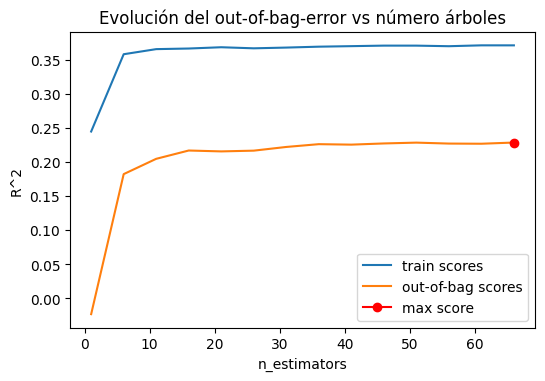

In [ ]:
# Validación empleando el Out-of-Bag error :

# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
estimator_range = range(1, 70, 5)

# Bucle para entrenar un modelo con cada valor de n_estimators y extraer su error
# de entrenamiento y de Out-of-Bag.

for n_estimators in estimator_range:

    modelRF = RandomForestRegressor(
                n_estimators = n_estimators,
                criterion    = 'squared_error', #mean squared error
                max_depth    = None,
                max_features = None,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelRF.fit(X_train, y_train)
    train_scores.append(modelRF.score(X_train, y_train))
    oob_scores.append(modelRF.oob_score_)



# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_ylabel("R^2")
ax.set_xlabel("n_estimators")
ax.set_title("Evolución del out-of-bag-error vs número árboles")
plt.legend();
print(f"Valor óptimo de n_estimators(árboles): {estimator_range[np.argmax(oob_scores)]}")

Ambos métodos indican que a partir de 20 arboles podemos tener un valor de evaluación estable

Valor óptimo de max_features: 40


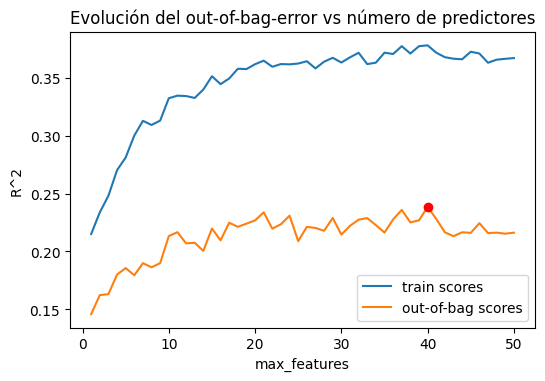

In [ ]:
# Validación empleando el Out-of-Bag error
# ==============================================================================
train_scores = []
oob_scores   = []

# Valores evaluados
max_features_range = range(1, X_train.shape[1] + 1, 1) #X_train.shape[1] = total de características


# Bucle para entrenar un modelo con cada valor de max_features y extraer su error
# de entrenamiento y de Out-of-Bag.
for max_features in max_features_range:
    modelRF = RandomForestRegressor(
                n_estimators = 20,
                criterion    = 'squared_error',
                max_depth    = None,
                max_features = max_features,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 123
             )
    modelRF.fit(X_train, y_train)
    train_scores.append(modelRF.score(X_train, y_train))
    oob_scores.append(modelRF.oob_score_)

# Gráfico con la evolución de los errores
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(max_features_range, train_scores, label="train scores")
ax.plot(max_features_range, oob_scores, label="out-of-bag scores")
ax.plot(max_features_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red")
ax.set_ylabel("R^2")
ax.set_xlabel("max_features")
ax.set_title("Evolución del out-of-bag-error vs número de predictores")
plt.legend();
print(f"Valor óptimo de max_features: {max_features_range[np.argmax(oob_scores)]}")

In [ ]:
#Se entrena el modelo con múltiples hiperparámetros buscando el mejor
modelRF = RandomForestRegressor(random_state = 123)

CV = 3

parameters =  {
                'n_estimators': [15, 20, 25],
                'max_features': [25, 30, 35],
                'max_depth'   : [3, 5, 10]
                }

grid_RF = GridSearchCV(
                    estimator  = modelRF,
                    param_grid = parameters,
                    scoring    =  'neg_root_mean_squared_error',         #'neg_root_mean_squared_error', 'r2'
                    n_jobs     = - 1,
                    cv         = CV,
                    refit      = True,
                    verbose    = 1,
                    return_train_score = True
                   )

grid_RF.fit(X = X_train, y = y_train)

Fitting 3 folds for each of 27 candidates, totalling 81 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=123), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 10], 'max_features': [25, 30, 35],
                         'n_estimators': [15, 20, 25]},
             return_train_score=True, scoring='neg_root_mean_squared_error',
             verbose=1)

In [ ]:
# Resultados
resultados = pd.DataFrame(grid_RF.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

param_max_depth  param_max_features  param_n_estimators  mean_test_score  \
14                5                  30                  25        -0.059998   
11                5                  25                  25        -0.060065   
13                5                  30                  20        -0.060131   
4                 3                  30                  20        -0.060173   

    std_test_score  mean_train_score  std_train_score  
14        0.002009         -0.051451         0.000793  
11        0.002328         -0.051955         0.000625  
13        0.002198         -0.051497         0.000819  
4         0.001838         -0.058134         0.001013

In [ ]:
# Se identifican los mejores hiperparámetros
best_params = grid_RF.best_params_
print('Best Parameters : ',best_params)

Best Parameters :  {'max_depth': 5, 'max_features': 30, 'n_estimators': 25}


In [ ]:
# Se crea un modelo árbol de decisión con los mejores hiperparámetros
modelRF = RandomForestRegressor( max_depth = best_params["max_depth"]
                               , max_features = best_params["max_features"]
                               , n_estimators = best_params["n_estimators"]
                               , random_state = 1234)


#Se entrena el modelo con los datos completos
modelRF.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, max_features=30, n_estimators=25,
                      random_state=1234)

In [ ]:
importancia_predictores = pd.DataFrame(
                            {'predictor': X_train.columns,
                             'importancia': modelRF.feature_importances_}
                            )
print("Importancia de los predictores en el modelo")
print("-------------------------------------------")
importancia_predictores.sort_values('importancia', ascending=False)

Importancia de los predictores en el modelo
-------------------------------------------


predictor  importancia
2                                     ROLLING_MEAN_7D     0.206817
38                      subcategory_Frutas y Verduras     0.142745
3                                            SLOPE_3D     0.097818
0                                     ROLLING_MEAN_1D     0.057903
6                                      ROLLING_STD_7D     0.057009
1                                     ROLLING_MEAN_3D     0.052516
42                              subcategory_Pasabocas     0.046022
12                                    ROLLING_SKEW_7D     0.044786
10                                     ROLLING_MAX_7D     0.042934
4                                            SLOPE_7D     0.039089
22  Tasa de exámenes médico legales por presunto d...     0.036208
37                       subcategory_Dulces y postres     0.034941
9                                      ROLLING_MAX_3D     0.022287
14  Cuarta medida correctiva al Código Nacional de...     0.017811
23      Tasa de extorsión por cada 100.000 habitantes     0.014040
18  Primera medida correctiva al Código Nacional d...     0.012740
5                                      ROLLING_STD_3D     0.012420
11                                    ROLLING_SKEW_3D     0.012298
36                               subcategory_Despensa     0.006424
24  Tasa de homicidio intencional en hombres por c...     0.005891
21  Quinta medida correctiva al Código Nacional de...     0.005847
13                                ROLLING_KURTOSIS_3D     0.005732
30           Índice de Interrelación de Problemáticas     0.004585
7                                      ROLLING_MIN_3D     0.004178
25  Tasa de homicidios en accidentes de tránsito p...     0.003620
15                   Fallecidos por siniestros viales     0.003157
34                       subcategory_Cuidado Personal     0.002972
8                                      ROLLING_MIN_7D     0.002808
26  Tasa de hurto a personas por cada 100.000 habi...     0.000893
16                    Porcentaje población de hombres     0.000836
19  Proporción en que son impuestas otras medidas ...     0.000776
40         subcategory_Lácteos, huevos y refrigerados     0.000639
46                                        Dpto_CALDAS     0.000632
20                Puntaje SISBEN: Promedio - Cabecera     0.000628
17                    Porcentaje población de mujeres     0.000000
32                                subcategory_Belleza     0.000000
33                            subcategory_Charcutería     0.000000
29  Tasa de violencia intrafamiliar por cada 100.0...     0.000000
27  Tasa de lesiones en accidentes de tránsito por...     0.000000
28      Tasa de secuestro por cada 100.000 habitantes     0.000000
31                                subcategory_Bebidas     0.000000
35              subcategory_Cuidado de ropa y calzado     0.000000
41                 subcategory_Panadería y Pastelería     0.000000
39                     subcategory_Limpieza de cocina     0.000000
44                       subcategory_Utiles Escolares     0.000000
43                   subcategory_Productos Congelados     0.000000
45                        subcategory_Vinos y Licores     0.000000
47                                       Dpto_QUINDÍO     0.000000
48                                     Dpto_RISARALDA     0.000000
49                               Dpto_VALLE DEL CAUCA     0.000000

In [ ]:
#los peores predictores
importancia_predictores.sort_values('importancia', ascending=False).tail(10)

predictor  importancia
31                    subcategory_Bebidas          0.0
35  subcategory_Cuidado de ropa y calzado          0.0
41     subcategory_Panadería y Pastelería          0.0
39         subcategory_Limpieza de cocina          0.0
44           subcategory_Utiles Escolares          0.0
43       subcategory_Productos Congelados          0.0
45            subcategory_Vinos y Licores          0.0
47                           Dpto_QUINDÍO          0.0
48                         Dpto_RISARALDA          0.0
49                   Dpto_VALLE DEL CAUCA          0.0

In [ ]:
importancia_predictores[importancia_predictores['importancia'] == 0]

predictor  importancia
17                    Porcentaje población de mujeres          0.0
27  Tasa de lesiones en accidentes de tránsito por...          0.0
28      Tasa de secuestro por cada 100.000 habitantes          0.0
29  Tasa de violencia intrafamiliar por cada 100.0...          0.0
31                                subcategory_Bebidas          0.0
32                                subcategory_Belleza          0.0
33                            subcategory_Charcutería          0.0
35              subcategory_Cuidado de ropa y calzado          0.0
39                     subcategory_Limpieza de cocina          0.0
41                 subcategory_Panadería y Pastelería          0.0
43                   subcategory_Productos Congelados          0.0
44                       subcategory_Utiles Escolares          0.0
45                        subcategory_Vinos y Licores          0.0
47                                       Dpto_QUINDÍO          0.0
48                                     Dpto_RISARALDA          0.0
49                               Dpto_VALLE DEL CAUCA          0.0

In [ ]:
#los mejores predictores
importancia_predictores.sort_values('importancia', ascending=False).head(10)

predictor  importancia
2                 ROLLING_MEAN_7D     0.206817
38  subcategory_Frutas y Verduras     0.142745
3                        SLOPE_3D     0.097818
0                 ROLLING_MEAN_1D     0.057903
6                  ROLLING_STD_7D     0.057009
1                 ROLLING_MEAN_3D     0.052516
42          subcategory_Pasabocas     0.046022
12                ROLLING_SKEW_7D     0.044786
10                 ROLLING_MAX_7D     0.042934
4                        SLOPE_7D     0.039089

In [ ]:
importancia_predictores.importancia.sum()

np.float64(1.0)

In [ ]:
# Error de train del mejor modelo
# ==============================================================================
predicciones = modelRF.predict(X = X_train)
y_train_escala = scaler_y.inverse_transform(y_train)
predicciones_escala = scaler_y.inverse_transform(predicciones.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_true  = y_train, y_pred  = predicciones))
print(f"El error (rmse) de train es: {rmse}")

r2 = r2_score(y_train, predicciones)
print(f"El error (r2) de train es: {r2}")

mape_train = mean_absolute_percentage_error(y_train, predicciones)
print(f"El MAPE de train es: {mape_train}")

El error (rmse) de train es: 0.053539835497325924
El error (r2) de train es: 0.3305407986498715
El MAPE de train es: 49775371458783.59


In [ ]:
# Error de test del mejor modelo
# ==============================================================================
predicciones = modelRF.predict(X = X_test)
y_test_escala = scaler_y.inverse_transform(y_test)
predicciones_escala = scaler_y.inverse_transform(predicciones.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_true  = y_test, y_pred  = predicciones))
print(f"El error (rmse) de test es: {rmse}")

r2 = r2_score(y_test, predicciones)
print(f"El error (r2) de test es: {r2}")

mape_test = mean_absolute_percentage_error(y_test, predicciones)
print(f"El MAPE de test es: {mape_test}")

El error (rmse) de test es: 0.048745625967409535
El error (r2) de test es: 0.24111568425502605
El MAPE de test es: 56986239039144.58


In [ ]:
evaluar_modelo('Random Forest', modelRF, X_train, y_train, X_test, y_test)

### XGBoost

In [ ]:
#Se entena el modelo con múltiples hiperparámetros buscando el mejor. Tarda 5 minutos

# Definir el modelo GradientBoosting
modelGrdB = GradientBoostingRegressor()

CV = 3

# Definir los parámetros a ajustar y sus posibles valores
parameters = {
    'n_estimators': [10, 25, 50, 75],
    'learning_rate': [0.1, 0.01, 0.001],
    'max_depth': [3, 5, 7]
}

grid_GrdB = GridSearchCV(
        estimator  = modelGrdB,
        param_grid = parameters,
        n_jobs     = - 1,
        cv         = CV,
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

grid_GrdB.fit(X = X_train, y = y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [10, 25, 50, 75]},
             return_train_score=True)

In [ ]:
# Resultados
# ==============================================================================
resultados = pd.DataFrame(grid_GrdB.cv_results_)
resultados.filter(regex = '(param*|mean_t|std_t)') \
    .drop(columns = 'params') \
    .sort_values('mean_test_score', ascending = False) \
    .head(4)

param_learning_rate  param_max_depth  param_n_estimators  mean_test_score  \
2                  0.1                3                  50         0.171788   
1                  0.1                3                  25         0.170543   
3                  0.1                3                  75         0.159032   
6                  0.1                5                  50         0.150010   

   std_test_score  mean_train_score  std_train_score  
2        0.038621          0.368776         0.018480  
1        0.027534          0.289529         0.015333  
3        0.051321          0.421711         0.020271  
6        0.065250          0.637212         0.019273

In [ ]:
# Se identifican los mejores hiperparámetros
best_params = grid_GrdB.best_params_
print('Best Parameters : ',best_params)

Best Parameters :  {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50}


In [ ]:
# Se crea un modelo árbol de decisión con los mejores hiperparámetros
modelGrdB = GradientBoostingRegressor(
                                        learning_rate = best_params["learning_rate"]
                                       , max_depth = best_params["max_depth"]
                                       , n_estimators = best_params["n_estimators"]
                                       , random_state = 1234)


#Se entrena el modelo con los datos completos
modelGrdB.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=50, random_state=1234)

In [ ]:
# Error de train del mejor modelo
# ==============================================================================
predicciones = modelGrdB.predict(X = X_train)
y_train_escala = scaler_y.inverse_transform(y_train)
predicciones_escala = scaler_y.inverse_transform(predicciones.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_true  = y_train_escala, y_pred  = predicciones_escala))
print(f"El error (rmse) de train es: {rmse}")

r2 = r2_score(y_train_escala, predicciones_escala)
print(f"El error (r2) de train es: {r2}")

mape_train = mean_absolute_percentage_error(y_train_escala, predicciones_escala)
print(f"El MAPE de train es: {mape_train}")

El error (rmse) de train es: 21.124445522728884
El error (r2) de train es: 0.32178318534627115
El MAPE de train es: 1.959173268834118e+16


In [ ]:
# Error de test del mejor modelo
# ==============================================================================
predicciones = modelGrdB.predict(X = X_test)
y_test_escala = scaler_y.inverse_transform(y_test)
predicciones_escala = scaler_y.inverse_transform(predicciones.reshape(-1, 1))

rmse = np.sqrt(mean_squared_error(y_true  = y_test_escala, y_pred = predicciones_escala))
print(f"El error (rmse) de test es: {rmse}")

r2 = r2_score(y_test_escala, predicciones_escala)
print(f"El error (r2) de test es: {r2}")

mape_test = mean_absolute_percentage_error(y_test_escala, predicciones_escala)
print(f"El MAPE de test es: {mape_test}")

El error (rmse) de test es: 18.995016904190397
El error (r2) de test es: 0.25008591901725774
El MAPE de test es: 2.1883380447672932e+16


In [ ]:
evaluar_modelo('Gradient Boosting', modelGrdB, X_train, y_train, X_test, y_test)

## 2.5. Modelos de Deep Learning

In [ ]:
#Evaluación del modelo
import sklearn.metrics as metrics
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

#optimizar modelos
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

#Modelos DL
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import RMSprop

In [ ]:
# Definir la arquitectura del modelo
model = Sequential()
model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))  # Capa de salida para regresión

# Compilar el modelo
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))


# Realizar predicciones
y_pred = model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)

# Calcular métricas adicionales
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

rmse_test = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test), y_pred))
r2_test = r2_score(scaler_y.inverse_transform(y_test), y_pred)
mape_test = mean_absolute_percentage_error(scaler_y.inverse_transform(y_test), y_pred)

print(f'RMSE en el conjunto de prueba: {rmse_test}')
print(f'R2 en el conjunto de prueba: {r2_test}')
print(f'MAPE en el conjunto de prueba: {mape_test}')

# Almacenar métricas en el DataFrame (si la función evaluar_modelo está definida para esto)
evaluar_modelo('Red Neuronal Básica', model, X_train, y_train, X_test, y_test) # Asegúrate de que evaluar_modelo funcione con modelos de Keras si es necesario


Epoch 1/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0128 - mae: 0.0679 - val_loss: 0.0031 - val_mae: 0.0308
Epoch 2/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0041 - mae: 0.0335 - val_loss: 0.0031 - val_mae: 0.0289
Epoch 3/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0044 - mae: 0.0341 - val_loss: 0.0030 - val_mae: 0.0260
Epoch 4/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0043 - mae: 0.0328 - val_loss: 0.0028 - val_mae: 0.0280
Epoch 5/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0034 - mae: 0.0312 - val_loss: 0.0027 - val_mae: 0.0262
Epoch 6/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0043 - mae: 0.0307 - val_loss: 0.0027 - val_mae: 0.0253
Epoch 7/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0033 - mae: 0.0288 - val_loss: 0.0026 - val_mae: 0.0240
Epoch 8/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0047 - mae: 0.0317 - val_loss: 0.0027 - val_mae: 0.0253
Epoch 9/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

In [ ]:
##modelo 2
model2 = Sequential()
model2.add(LSTM(128, input_shape=(X_train.shape[1], 1), return_sequences=True))
model2.add(Dropout(0.3))
model2.add(LSTM(64, return_sequences=True))
model2.add(Dropout(0.3))
model2.add(LSTM(32, return_sequences=False))
model2.add(Dense(16, activation='relu'))
model2.add(Dense(1, activation='linear'))  # Capa de salida

# Compilar el modelo
optimizer = RMSprop(learning_rate=0.001)
model2.compile(loss='mse', optimizer=optimizer, metrics=['mae'])


# Entrenar el modelo con Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Número de épocas sin mejora antes de detenerse
    restore_best_weights=True,  # Recupera los mejores pesos alcanzados
    verbose=1
)
history = model2.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test),
                     callbacks=[early_stopping])

# Realizar predicciones
y_pred = model2.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)

# Calcular métricas adicionales
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

rmse_test = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test), y_pred))
r2_test = r2_score(scaler_y.inverse_transform(y_test), y_pred)
mape_test = mean_absolute_percentage_error(scaler_y.inverse_transform(y_test), y_pred)

print(f'RMSE en el conjunto de prueba: {rmse_test}')
print(f'R2 en el conjunto de prueba: {r2_test}')
print(f'MAPE en el conjunto de prueba: {mape_test}')

# Almacenar métricas en el DataFrame (si la función evaluar_modelo está definida para esto)
evaluar_modelo('LSTM Básica', model2, X_train, y_train, X_test, y_test) # Asegúrate de que evaluar_modelo funcione con modelos de Keras si es necesario


Epoch 1/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 30s 121ms/step - loss: 0.0053 - mae: 0.0365 - val_loss: 0.0031 - val_mae: 0.0311
Epoch 2/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 24s 117ms/step - loss: 0.0050 - mae: 0.0351 - val_loss: 0.0034 - val_mae: 0.0419
Epoch 3/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 40s 113ms/step - loss: 0.0040 - mae: 0.0330 - val_loss: 0.0031 - val_mae: 0.0334
Epoch 4/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 41s 115ms/step - loss: 0.0050 - mae: 0.0352 - val_loss: 0.0030 - val_mae: 0.0287
Epoch 5/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 24s 115ms/step - loss: 0.0034 - mae: 0.0302 - val_loss: 0.0030 - val_mae: 0.0299
Epoch 6/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 41s 117ms/step - loss: 0.0035 - mae: 0.0303 - val_loss: 0.0029 - val_mae: 0.0292
Epoch 7/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 24s 116ms/step - loss: 0.0039 - mae: 0.0310 - val_loss: 0.0031 - val_mae: 0.0347
Epoch 8/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 41s 118ms/step - loss: 0.0036 - mae: 0.0308 - val_loss: 0.0029 - val_mae: 0.0266
Epoch 9/50
208/208 ━━━━━━━━━━━━━

In [ ]:
pip install scikeras

In [ ]:
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.optimizers import RMSprop

# Define the Keras model architecture within a function
def build_keras_model(input_shape):
    model = Sequential()
    model.add(Dense(128, input_shape=(input_shape,), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Create the KerasRegressor, passing the build function and the input shape
keras_model = KerasRegressor(model=build_keras_model, input_shape=X_train.shape[1],
                             epochs=50, batch_size=32
                             )

# Fit and score the estimator
keras_model.fit(X_train, y_train, validation_data=(X_test, y_test))

# Realizar keras_model
y_pred = keras_model.predict(X_test)
y_pred = scaler_y.inverse_transform(y_pred)

# Calcular métricas adicionales
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error

rmse_test = np.sqrt(mean_squared_error(scaler_y.inverse_transform(y_test), y_pred))
r2_test = r2_score(scaler_y.inverse_transform(y_test), y_pred)
mape_test = mean_absolute_percentage_error(scaler_y.inverse_transform(y_test), y_pred)

print(f'RMSE en el conjunto de prueba: {rmse_test}')
print(f'R2 en el conjunto de prueba: {r2_test}')
print(f'MAPE en el conjunto de prueba: {mape_test}')

# Almacenar métricas en el DataFrame (si la función evaluar_modelo está definida para esto)
evaluar_modelo('Keras Regresor Básico', keras_model, X_train, y_train, X_test, y_test)


Epoch 1/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0073 - mae: 0.0500 - val_loss: 0.0032 - val_mae: 0.0309
Epoch 2/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0045 - mae: 0.0345 - val_loss: 0.0031 - val_mae: 0.0309
Epoch 3/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0041 - mae: 0.0339 - val_loss: 0.0031 - val_mae: 0.0308
Epoch 4/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0044 - mae: 0.0346 - val_loss: 0.0030 - val_mae: 0.0309
Epoch 5/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0042 - mae: 0.0340 - val_loss: 0.0030 - val_mae: 0.0261
Epoch 6/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0043 - mae: 0.0334 - val_loss: 0.0031 - val_mae: 0.0226
Epoch 7/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0039 - mae: 0.0315 - val_loss: 0.0029 - val_mae: 0.0280
Epoch 8/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0038 - mae: 0.0303 - val_loss: 0.0032 - val_mae: 0.0204
Epoch 9/50
208/208 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step -

## 2.6. Resumen resultados

In [ ]:
# Exportar DataFrame a CSV
df_metricas.to_csv('metricas_modelos_con_rellenado.csv', index=False)

df_metricas

Modelo  RMSE_train      R2_train    MAPE_train  RMSE_test  \
0                   SVMR    6.652433 -10334.489286  1.098078e+16   6.832694   
1        modelElasticNet    8.397338 -16467.473358  2.894428e+16   8.400801   
2          Random Forest   13.887501 -45041.059779  1.951195e+16  14.116525   
3      Gradient Boosting   14.064803 -46198.511726  1.959173e+16  13.613104   
4    Red Neuronal Básica   18.134881 -76805.768527  2.418167e+16  19.248350   
5            LSTM Básica    9.190383 -19724.918642  1.951116e+16   9.383257   
6  Keras Regresor Básico    8.040639 -15098.104245  1.899050e+16   8.271557   

         R2_test     MAPE_test  
0  -14909.361195  1.264024e+16  
1  -22538.571656  2.976988e+16  
2  -63643.350859  2.233861e+16  
3  -59184.945778  2.188338e+16  
4 -118328.021942  2.944930e+16  
5  -28118.754352  2.139088e+16  
6  -21850.377256  2.084159e+16

## 2.7. Predicciones datos de prueba

In [ ]:
## Generar columnas Dummy
dp_pruebas_rellenado = pd.get_dummies(dp_pruebas_rellenado, drop_first=1)

# Convertir todas las columnas booleanas a enteros
for col in dp_pruebas_rellenado.select_dtypes(include='bool').columns:
    dp_pruebas_rellenado[col] = dp_pruebas_rellenado[col].astype(int)

In [ ]:
df_modelo.shape, dp_pruebas_rellenado.shape

((8865, 52), (2089, 52))

In [ ]:
##columnas que estan en dp_pruebas_rellenado y no en df_modelo
dp_pruebas_rellenado.columns.difference(df_modelo.columns)

Index([], dtype='object')

In [ ]:
X_prueba = dp_pruebas_rellenado.drop(columns = ["CANTIDAD", 'FECHA'])
y_prueba = dp_pruebas_rellenado['CANTIDAD']

In [ ]:
scaler #usamos el mismo scaler usado en entrenamiento

MinMaxScaler()

In [ ]:
# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_prueba[num_vars] = scaler.transform(X_prueba[num_vars])
X_prueba[num_vars] = X_prueba[num_vars].fillna(0)
X_prueba[num_vars].sample(2)

ROLLING_MEAN_1D  ROLLING_MEAN_3D  ROLLING_MEAN_7D  SLOPE_3D  SLOPE_7D  \
19597         0.005842         0.002946         0.002820  0.614150  0.355825   
19924         0.000000        -0.000589         0.006204  0.610583  0.353189   

       ROLLING_STD_3D  ROLLING_STD_7D  ROLLING_MIN_3D  ROLLING_MIN_7D  \
19597        0.005842        0.005374             0.0             0.0   
19924        0.000000        0.010749             0.0             0.0   

       ROLLING_MAX_3D  ...  subcategory_Lácteos, huevos y refrigerados  \
19597        0.004873  ...                                         0.0   
19924       -0.000975  ...                                         0.0   

       subcategory_Panadería y Pastelería  subcategory_Pasabocas  \
19597                                 0.0                    0.0   
19924                                 0.0                    0.0   

       subcategory_Productos Congelados  subcategory_Utiles Escolares  \
19597                               0.0                           0.0   
19924                               0.0                           0.0   

       subcategory_Vinos y Licores  Dpto_CALDAS  Dpto_QUINDÍO  Dpto_RISARALDA  \
19597                          0.0          0.0           0.0             0.0   
19924                          0.0          0.0           1.0             0.0   

       Dpto_VALLE DEL CAUCA  
19597                   0.0  
19924                   0.0  

[2 rows x 50 columns]

In [ ]:
X_prueba.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2089 entries, 19115 to 21203
Data columns (total 50 columns):
 #   Column                                                                                                 Non-Null Count  Dtype  
---  ------                                                                                                 --------------  -----  
 0   ROLLING_MEAN_1D                                                                                        2089 non-null   float64
 1   ROLLING_MEAN_3D                                                                                        2089 non-null   float64
 2   ROLLING_MEAN_7D                                                                                        2089 non-null   float64
 3   SLOPE_3D                                                                                               2089 non-null   float64
 4   SLOPE_7D                                                                                        

In [ ]:
##predecir con los modelos entrenados
predicciones_svm = SVMR_Pol_opt.predict(X_prueba)
predicciones_elastic = modelElasticNet.predict(X_prueba)
predicciones_rf = modelRF.predict(X_prueba)
predicciones_gb = modelGrdB.predict(X_prueba)

predicciones_dl_basico = model.predict(X_prueba)
predicciones_lstm_basico = model2.predict(X_prueba)
predicciones_keras_basico = keras_model.predict(X_prueba)

#reescalar
predicciones_svm = scaler_y.inverse_transform(predicciones_svm.reshape(-1, 1))
predicciones_elastic = scaler_y.inverse_transform(predicciones_elastic.reshape(-1, 1))
predicciones_rf = scaler_y.inverse_transform(predicciones_rf.reshape(-1, 1))
predicciones_gb = scaler_y.inverse_transform(predicciones_gb.reshape(-1, 1))

predicciones_dl_basico = scaler_y.inverse_transform(predicciones_dl_basico)
predicciones_lstm_basico = scaler_y.inverse_transform(predicciones_lstm_basico)
predicciones_keras_basico = scaler_y.inverse_transform(predicciones_keras_basico)

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [ ]:
dp_pruebas_rellenado_original = pd.read_csv('df_pruebas_rellenado.csv')
dp_pruebas_rellenado_original.set_index(y_prueba.index, inplace=True)

In [ ]:
##crear dataframe con y_prueba, predicciones de cada modelo
df_predicciones = pd.DataFrame({'FECHA': dp_pruebas_rellenado_original['FECHA'],
                                'Dpto': dp_pruebas_rellenado_original['Dpto'],
                                'subcategory': dp_pruebas_rellenado_original['subcategory'],
                                'y_prueba': y_prueba,
                                # 'y_prueba_revision': dp_pruebas_rellenado_original['CANTIDAD'],
                                'predicciones_svr':predicciones_svm.flatten(), # Flatten the array
                                'predicciones_elastic':predicciones_elastic.flatten(), # Flatten the array
                                'predicciones_rf':predicciones_rf.flatten(), # Flatten the array
                                'predicciones_gb':predicciones_gb.flatten(), # Flatten the array

                                'predicciones_dl_basico':predicciones_dl_basico.flatten(), # Flatten the array
                                'predicciones_lstm':predicciones_lstm_basico.flatten(), # Flatten the array
                                'predicciones_kerasR':predicciones_keras_basico.flatten()}) # Flatten the array
df_predicciones.sample(10)

FECHA             Dpto             subcategory  y_prueba  \
19470  2022-09-08        RISARALDA    Productos Congelados       0.0   
19118  2022-09-04           CALDAS  Panadería y Pastelería       0.0   
19389  2022-09-07          QUINDÍO       Frutas y Verduras      12.0   
20674  2022-09-24           CALDAS         Vinos y Licores       0.0   
19896  2022-09-13        ANTIOQUIA           Aseo de hogar       0.0   
21000  2022-09-28        ANTIOQUIA      Limpieza de cocina       0.0   
20838  2022-09-26        RISARALDA             Charcutería       0.0   
20016  2022-09-15        ANTIOQUIA                 Bebidas       0.0   
20996  2022-09-28  VALLE DEL CAUCA        Dulces y postres      45.0   
21057  2022-09-29        ANTIOQUIA           Aseo de hogar       0.0   

       predicciones_svr  predicciones_elastic  predicciones_rf  \
19470          2.760209              8.418559         0.758871   
19118          1.724660              8.418559         0.851869   
19389          3.820072              8.418559         6.585051   
20674          1.252865              8.418559         0.831456   
19896          3.124973              8.418559         5.355321   
21000          4.085221              8.418559         7.451215   
20838         -0.307251              8.418559         0.554638   
20016          3.648218              8.418559        15.912311   
20996          4.064678              8.418559        19.804294   
21057          3.596455              8.418559         4.934482   

       predicciones_gb  predicciones_dl_basico  predicciones_lstm  \
19470        -1.879975                1.154749          -1.099399   
19118        -2.499438                1.182010           3.352019   
19389         8.476206                3.212244           4.734961   
20674         0.281709                0.604906          -3.759267   
19896         2.052903                9.981433           3.795903   
21000         8.415641               14.905053          22.424704   
20838        -0.370553                1.075109          -5.316627   
20016        14.384700                3.299001           1.861808   
20996         8.223611               19.271780          14.557005   
21057         0.221483               11.892326           3.607403   

       predicciones_kerasR  
19470             3.643330  
19118             3.643330  
19389             3.644735  
20674             3.643330  
19896             6.858054  
21000             6.386884  
20838             3.643330  
20016             3.643330  
20996            13.525233  
21057             7.586014

In [ ]:
# prompt: Calcule el RMSE, R2 y MAPE de las predicciones para cada subregion y cada subcategoria

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Crear un DataFrame vacío para almacenar métricas por subregión y subcategoría
df_metricas_detalle = pd.DataFrame(columns=['Dpto', 'subcategory',
                                            'Modelo', 'RMSE', 'R2', 'MAPE'])

# Iterar sobre cada subregión única
for subregion in df_predicciones['Dpto'].unique():
    # Iterar sobre cada subcategoría única dentro de la subregión
    for subcategory in df_predicciones[df_predicciones['Dpto'] == subregion]['subcategory'].unique():
        # Filtrar el DataFrame para la subregión y subcategoría actuales
        df_subset = df_predicciones[(df_predicciones['Dpto'] == subregion) &
                                    (df_predicciones['subcategory'] == subcategory)].copy()

        if len(df_subset) > 1: # Ensure there are enough samples to calculate metrics
            y_true_subset = df_subset['y_prueba']

            # Calculate metrics for each model
            models = ['predicciones_svr', 'predicciones_elastic', 'predicciones_rf', 'predicciones_gb',
                'predicciones_dl_basico', 'predicciones_lstm', 'predicciones_kerasR']
            model_names = ['SVR', 'ElasticNet', 'Random Forest', 'Gradient Boosting',
                'Red Neuronal Básica', 'LSTM Básica', 'Keras Regresor Básico']

            for model_col, model_name in zip(models, model_names):
                y_pred_subset = df_subset[model_col]

                # Calculate metrics
                rmse = np.sqrt(metrics.mean_squared_error(y_true_subset, y_pred_subset))
                r2 = metrics.r2_score(y_true_subset, y_pred_subset)

                # Avoid division by zero in MAPE calculation for cases where actual values are zero
                if (y_true_subset == 0).any():
                    mape = np.nan # Or some other indicator, as MAPE is not well-defined when true values are zero
                else:
                    mape = mean_absolute_percentage_error(y_true_subset, y_pred_subset)


                # Agregar resultados al DataFrame
                df_metricas_detalle = pd.concat([df_metricas_detalle, pd.DataFrame({
                    'Dpto': [subregion],
                    'subcategory': [subcategory],
                    'Modelo': [model_name],
                    'RMSE': [rmse],
                    'R2': [r2],
                    'MAPE': [mape]
                })], ignore_index=True)

# Display the resulting DataFrame
print("Métricas por Subregión y Subcategoría:")
df_metricas_detalle


Métricas por Subregión y Subcategoría:


Dpto           subcategory                 Modelo      RMSE  \
0    ANTIOQUIA  Productos Congelados                    SVR  3.702111   
1    ANTIOQUIA  Productos Congelados             ElasticNet  8.021109   
2    ANTIOQUIA  Productos Congelados          Random Forest  4.702511   
3    ANTIOQUIA  Productos Congelados      Gradient Boosting  2.895260   
4    ANTIOQUIA  Productos Congelados    Red Neuronal Básica  3.334628   
..         ...                   ...                    ...       ...   
555  RISARALDA      Dulces y postres          Random Forest  3.321721   
556  RISARALDA      Dulces y postres      Gradient Boosting  1.570523   
557  RISARALDA      Dulces y postres    Red Neuronal Básica  2.741560   
558  RISARALDA      Dulces y postres            LSTM Básica  5.071321   
559  RISARALDA      Dulces y postres  Keras Regresor Básico  3.643330   

           R2  MAPE  
0   -1.101683   NaN  
1   -8.865911   NaN  
2   -2.391001   NaN  
3   -0.285416   NaN  
4   -0.705152   NaN  
..        ...   ...  
555  0.000000   NaN  
556  0.000000   NaN  
557  0.000000   NaN  
558  0.000000   NaN  
559  0.000000   NaN  

[560 rows x 6 columns]

In [ ]:
df_predicciones[['Dpto', 'subcategory']].value_counts()

Dpto       subcategory              
ANTIOQUIA  Aseo de hogar                27
           Bebidas                      27
           Belleza                      27
           Charcutería                  27
           Cuidado Personal             27
                                        ..
QUINDÍO    Cuidado Personal             26
RISARALDA  Utiles Escolares             14
CALDAS     Cuidado de ropa y calzado    13
QUINDÍO    Belleza                       6
           Cuidado de ropa y calzado     5
Name: count, Length: 80, dtype: int64

In [ ]:
df_predicciones[(df_predicciones['Dpto']=='ANTIOQUIA') & (df_predicciones['subcategory']=='Frutas y Verduras')]

FECHA       Dpto        subcategory  y_prueba  predicciones_svr  \
19143  2022-09-04  ANTIOQUIA  Frutas y Verduras       0.0         16.122847   
19253  2022-09-05  ANTIOQUIA  Frutas y Verduras       0.0          9.804906   
19335  2022-09-06  ANTIOQUIA  Frutas y Verduras       0.0         19.946559   
19412  2022-09-07  ANTIOQUIA  Frutas y Verduras     176.0          8.943605   
19447  2022-09-08  ANTIOQUIA  Frutas y Verduras      95.0         37.288388   
19534  2022-09-09  ANTIOQUIA  Frutas y Verduras      70.0         24.149689   
19594  2022-09-10  ANTIOQUIA  Frutas y Verduras      56.0         15.569704   
19726  2022-09-11  ANTIOQUIA  Frutas y Verduras       0.0         13.570374   
19803  2022-09-12  ANTIOQUIA  Frutas y Verduras       0.0         11.302098   
19881  2022-09-13  ANTIOQUIA  Frutas y Verduras       0.0         21.631831   
19983  2022-09-14  ANTIOQUIA  Frutas y Verduras     201.0         11.459187   
20050  2022-09-15  ANTIOQUIA  Frutas y Verduras     224.0         40.393387   
20110  2022-09-16  ANTIOQUIA  Frutas y Verduras      17.0         31.119885   
20185  2022-09-17  ANTIOQUIA  Frutas y Verduras     145.0         11.094436   
20217  2022-09-18  ANTIOQUIA  Frutas y Verduras       0.0         20.432406   
20350  2022-09-19  ANTIOQUIA  Frutas y Verduras      20.0         23.224103   
20375  2022-09-20  ANTIOQUIA  Frutas y Verduras      34.0         22.108737   
20505  2022-09-21  ANTIOQUIA  Frutas y Verduras      87.0         17.746204   
20523  2022-09-22  ANTIOQUIA  Frutas y Verduras      34.0         24.968006   
20655  2022-09-23  ANTIOQUIA  Frutas y Verduras      44.0         21.136541   
20715  2022-09-24  ANTIOQUIA  Frutas y Verduras       8.0         19.801998   
20811  2022-09-25  ANTIOQUIA  Frutas y Verduras       0.0         12.866671   
20842  2022-09-26  ANTIOQUIA  Frutas y Verduras       0.0         22.443644   
20933  2022-09-27  ANTIOQUIA  Frutas y Verduras       0.0         23.721985   
21002  2022-09-28  ANTIOQUIA  Frutas y Verduras       8.0         11.688998   
21127  2022-09-29  ANTIOQUIA  Frutas y Verduras      66.0         25.234652   
21179  2022-09-30  ANTIOQUIA  Frutas y Verduras      28.0         29.332601   

       predicciones_elastic  predicciones_rf  predicciones_gb  \
19143              8.418559        25.768632        27.093453   
19253              8.418559        24.732598        24.081395   
19335              8.418559        27.468563        36.305823   
19412              8.418559        75.448641        56.777530   
19447              8.418559        65.691855       104.068486   
19534              8.418559        50.005211        58.691181   
19594              8.418559        31.816042        31.773003   
19726              8.418559        27.422893        27.775356   
19803              8.418559        25.721941        19.575358   
19881              8.418559        26.237616        32.994868   
19983              8.418559        75.448641        56.777530   
20050              8.418559        65.691855        78.377926   
20110              8.418559        62.619958        79.598959   
20185              8.418559        30.530144        32.487142   
20217              8.418559        32.910644        29.248188   
20350              8.418559        26.883510        21.836380   
20375              8.418559        25.229430        35.567273   
20505              8.418559        62.404044        56.666600   
20523              8.418559        56.387321        60.149201   
20655              8.418559        47.812517        48.787539   
20715              8.418559        26.268127        36.139529   
20811              8.418559        27.388677        31.281567   
20842              8.418559        29.744596        36.408723   
20933              8.418559        36.428823        46.023973   
21002              8.418559        74.938877        65.160758   
21127              8.418559        55.010133        47.705350   
21179              8.418559        37.517954

In [ ]:
##las mejores predicciones
df_metricas_detalle.sort_values(by="RMSE", ascending=True).head(10)

Dpto                subcategory               Modelo  \
383          QUINDÍO                    Belleza          LSTM Básica   
299  VALLE DEL CAUCA            Vinos y Licores          LSTM Básica   
424          QUINDÍO     Panadería y Pastelería  Red Neuronal Básica   
417          QUINDÍO            Vinos y Licores  Red Neuronal Básica   
138           CALDAS           Utiles Escolares          LSTM Básica   
382          QUINDÍO                    Belleza  Red Neuronal Básica   
131           CALDAS  Cuidado de ropa y calzado          LSTM Básica   
431          QUINDÍO  Cuidado de ropa y calzado  Red Neuronal Básica   
389          QUINDÍO                    Bebidas  Red Neuronal Básica   
294  VALLE DEL CAUCA            Vinos y Licores                  SVR   

         RMSE   R2  MAPE  
383  0.026582  0.0   NaN  
299  0.169228  0.0   NaN  
424  0.249693  0.0   NaN  
417  0.259463  0.0   NaN  
138  0.262951  0.0   NaN  
382  0.305471  0.0   NaN  
131  0.305654  0.0   NaN  
431  0.322808  0.0   NaN  
389  0.433039  0.0   NaN  
294  0.464110  0.0   NaN

In [ ]:
##las peores predicciones
df_metricas_detalle.sort_values(by="RMSE", ascending=True).tail(10)

Dpto        subcategory                 Modelo       RMSE        R2  \
96  ANTIOQUIA          Pasabocas            LSTM Básica  52.378172 -0.195375   
91  ANTIOQUIA          Pasabocas                    SVR  53.390918 -0.242048   
92  ANTIOQUIA          Pasabocas             ElasticNet  53.412594 -0.243057   
30  ANTIOQUIA  Frutas y Verduras          Random Forest  55.247451  0.274305   
31  ANTIOQUIA  Frutas y Verduras      Gradient Boosting  57.823008  0.205066   
33  ANTIOQUIA  Frutas y Verduras            LSTM Básica  68.033083 -0.100449   
32  ANTIOQUIA  Frutas y Verduras    Red Neuronal Básica  69.823934 -0.159146   
28  ANTIOQUIA  Frutas y Verduras                    SVR  70.262591 -0.173756   
34  ANTIOQUIA  Frutas y Verduras  Keras Regresor Básico  70.439066 -0.179660   
29  ANTIOQUIA  Frutas y Verduras             ElasticNet  76.308199 -0.384433   

    MAPE  
96   NaN  
91   NaN  
92   NaN  
30   NaN  
31   NaN  
33   NaN  
32   NaN  
28   NaN  
34   NaN  
29   NaN

In [ ]:
df_predicciones['FECHA'] = pd.to_datetime(df_predicciones['FECHA'])

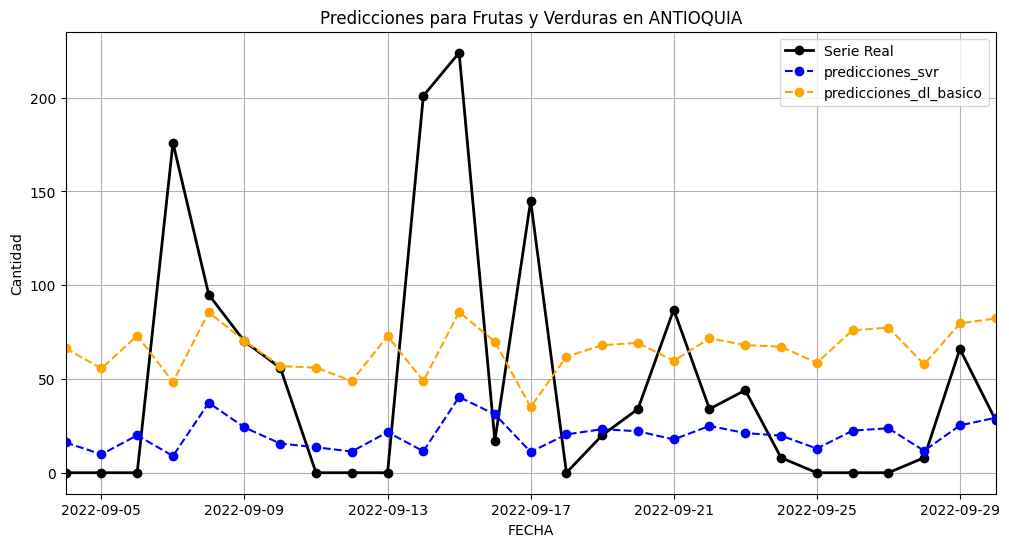

Métricas para Frutas y Verduras en ANTIOQUIA:
         Dpto        subcategory                 Modelo       RMSE        R2  \
28  ANTIOQUIA  Frutas y Verduras                    SVR  70.262591 -0.173756   
29  ANTIOQUIA  Frutas y Verduras             ElasticNet  76.308199 -0.384433   
30  ANTIOQUIA  Frutas y Verduras          Random Forest  55.247451  0.274305   
31  ANTIOQUIA  Frutas y Verduras      Gradient Boosting  57.823008  0.205066   
32  ANTIOQUIA  Frutas y Verduras    Red Neuronal Básica  69.823934 -0.159146   
33  ANTIOQUIA  Frutas y Verduras            LSTM Básica  68.033083 -0.100449   
34  ANTIOQUIA  Frutas y Verduras  Keras Regresor Básico  70.439066 -0.179660   

    MAPE  
28   NaN  
29   NaN  
30   NaN  
31   NaN  
32   NaN  
33   NaN  
34   NaN  


In [ ]:
def plot_subregion_subcategory_predictions(df_predicciones, subregion_name, subcategory_name, modelos_a_graficar):
    """ Grafica la serie real y las predicciones de modelos específicos. """
    df_subset = df_predicciones[
        (df_predicciones['Dpto'] == subregion_name) &
        (df_predicciones['subcategory'] == subcategory_name)
    ].copy()

    if df_subset.empty:
        print(f"No hay datos para {subregion_name} - {subcategory_name}")
        return

    df_subset = df_subset.sort_values(by='FECHA')

    plt.figure(figsize=(12, 6))
    plt.plot(df_subset['FECHA'], df_subset['y_prueba'], label='Serie Real', marker='o', linewidth=2, color='black')

    colores = {
        'predicciones_svr': 'blue',
        'predicciones_elastic': 'green',
        'predicciones_rf': 'red',
        'predicciones_gb': 'purple',
        'predicciones_dl_basico': 'orange',
        'predicciones_lstm': 'brown',
        'predicciones_kerasR': 'pink'
    }

    for modelo in modelos_a_graficar:
        if modelo in df_subset.columns:
            plt.plot(df_subset['FECHA'], df_subset[modelo], label=modelo, marker='o', linestyle='dashed', color=colores.get(modelo, 'gray'))

    plt.xlabel('FECHA')
    plt.ylabel('Cantidad')
    # plt.xticks(rotation=90)
    plt.title(f'Predicciones para {subcategory_name} en {subregion_name}')
    plt.xlim(df_subset['FECHA'].min(), df_subset['FECHA'].max())
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"Métricas para {subcategory_name} en {subregion_name}:")
    print(df_metricas_detalle[
        (df_metricas_detalle['Dpto'] == subregion_name) &
        (df_metricas_detalle['subcategory'] == subcategory_name)
    ])

# Selección de modelos específicos
modelos_seleccionados = ['predicciones_svr','predicciones_dl_basico']
plot_subregion_subcategory_predictions(df_predicciones, 'ANTIOQUIA', 'Frutas y Verduras', modelos_seleccionados)

In [ ]:
df_metricas

Modelo  RMSE_train      R2_train    MAPE_train  RMSE_test  \
0                   SVMR    6.652433 -10334.489286  1.098078e+16   6.832694   
1        modelElasticNet    8.397338 -16467.473358  2.894428e+16   8.400801   
2          Random Forest   13.887501 -45041.059779  1.951195e+16  14.116525   
3      Gradient Boosting   14.064803 -46198.511726  1.959173e+16  13.613104   
4    Red Neuronal Básica   18.134881 -76805.768527  2.418167e+16  19.248350   
5            LSTM Básica    9.190383 -19724.918642  1.951116e+16   9.383257   
6  Keras Regresor Básico    8.040639 -15098.104245  1.899050e+16   8.271557   

         R2_test     MAPE_test  
0  -14909.361195  1.264024e+16  
1  -22538.571656  2.976988e+16  
2  -63643.350859  2.233861e+16  
3  -59184.945778  2.188338e+16  
4 -118328.021942  2.944930e+16  
5  -28118.754352  2.139088e+16  
6  -21850.377256  2.084159e+16

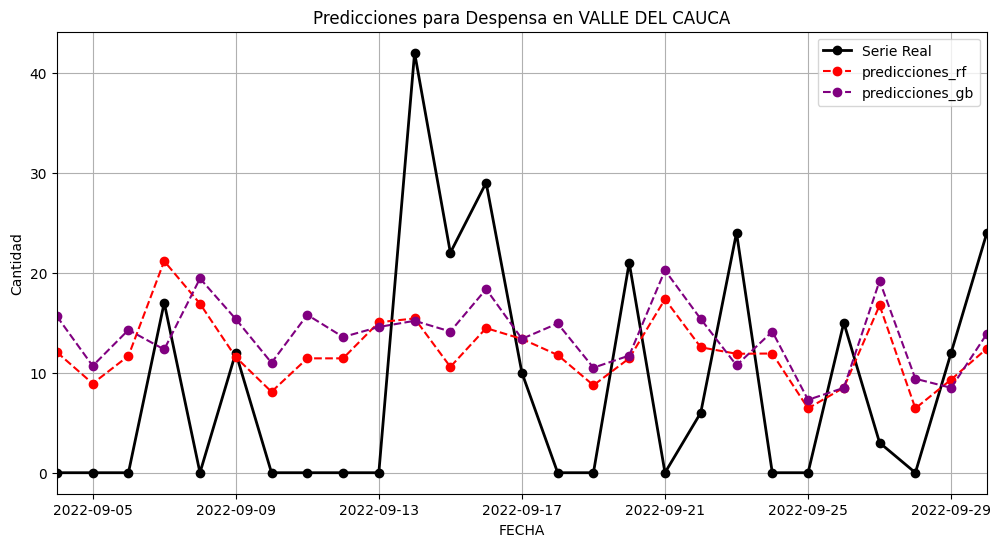

Métricas para Despensa en VALLE DEL CAUCA:
                Dpto subcategory                 Modelo       RMSE        R2  \
308  VALLE DEL CAUCA    Despensa                    SVR  12.440315 -0.177501   
309  VALLE DEL CAUCA    Despensa             ElasticNet  11.470010 -0.000982   
310  VALLE DEL CAUCA    Despensa          Random Forest  11.660365 -0.034482   
311  VALLE DEL CAUCA    Despensa      Gradient Boosting  12.906446 -0.267395   
312  VALLE DEL CAUCA    Despensa    Red Neuronal Básica  14.770028 -0.659821   
313  VALLE DEL CAUCA    Despensa            LSTM Básica  11.475532 -0.001946   
314  VALLE DEL CAUCA    Despensa  Keras Regresor Básico  12.027996 -0.100741   

     MAPE  
308   NaN  
309   NaN  
310   NaN  
311   NaN  
312   NaN  
313   NaN  
314   NaN  


In [ ]:
# Selección de modelos específicos
modelos_seleccionados = ['predicciones_rf', 'predicciones_gb']
plot_subregion_subcategory_predictions(df_predicciones, 'VALLE DEL CAUCA', 'Despensa', modelos_seleccionados)

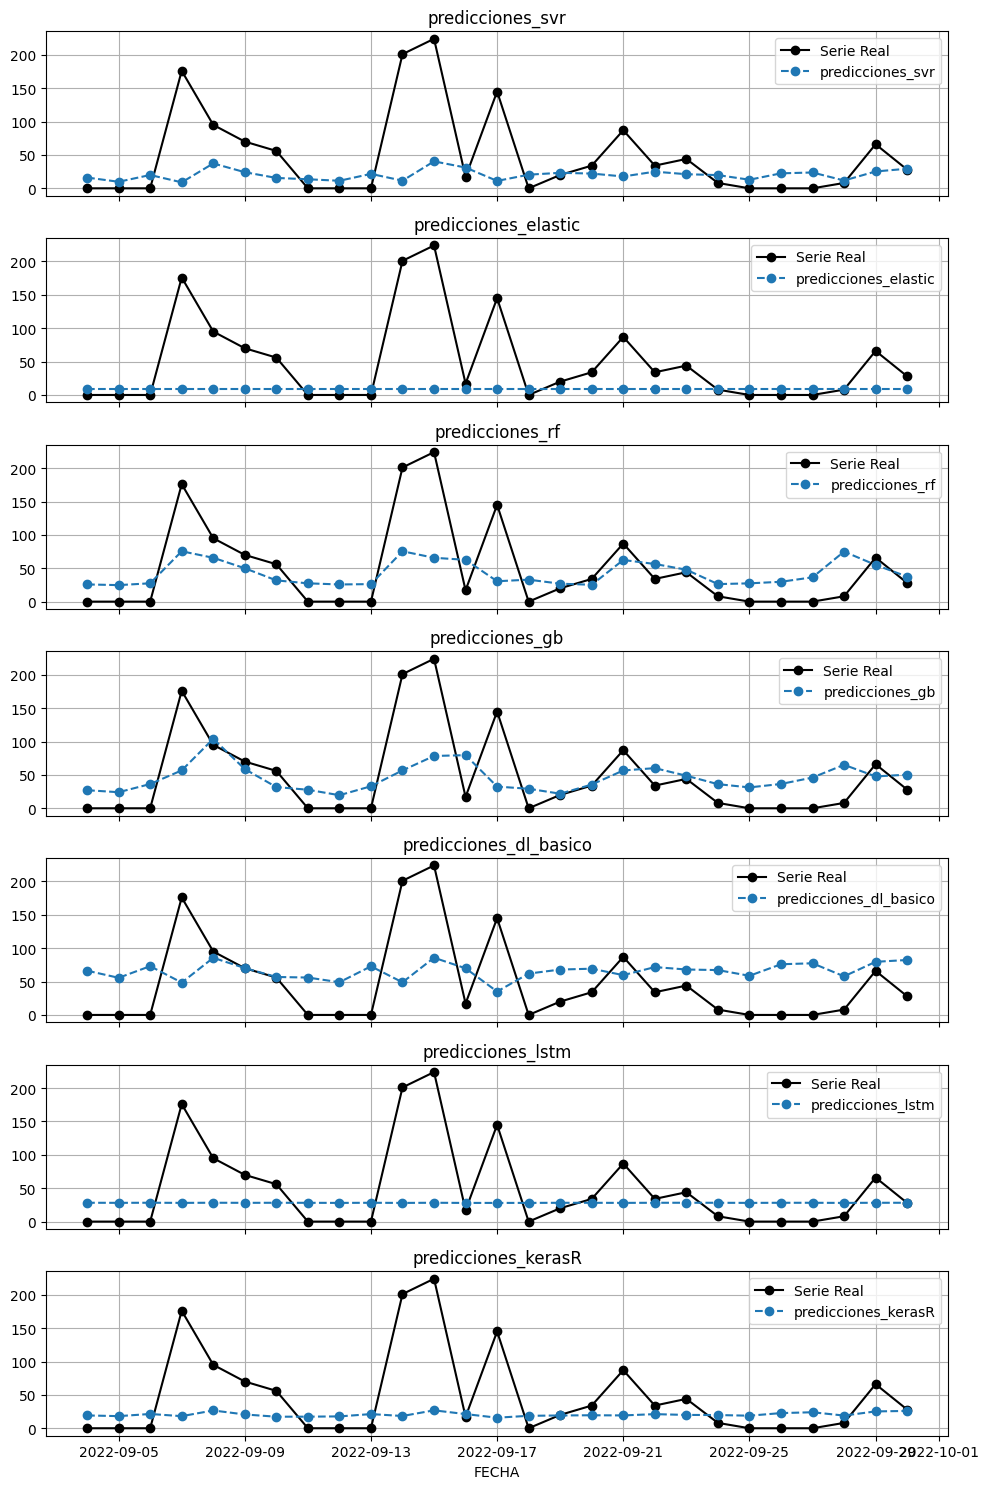

In [ ]:
def plot_subregion_subcategory_predictions_subplot(df_predicciones, subregion_name, subcategory_name):
    modelos = ['predicciones_svr', 'predicciones_elastic', 'predicciones_rf', 'predicciones_gb',
               'predicciones_dl_basico', 'predicciones_lstm', 'predicciones_kerasR']

    df_subset = df_predicciones[
        (df_predicciones['Dpto'] == subregion_name) &
        (df_predicciones['subcategory'] == subcategory_name)
    ].copy()

    if df_subset.empty:
        print(f"No hay datos para {subregion_name} - {subcategory_name}")
        return

    df_subset = df_subset.sort_values(by='FECHA')

    fig, axes = plt.subplots(nrows=len(modelos), ncols=1, figsize=(10, 15), sharex=True)

    for i, modelo in enumerate(modelos):
        if modelo in df_subset.columns:
            axes[i].plot(df_subset['FECHA'], df_subset['y_prueba'], label='Serie Real', marker='o', color='black')
            axes[i].plot(df_subset['FECHA'], df_subset[modelo], label=modelo, marker='o', linestyle='dashed')
            axes[i].set_title(f'{modelo}')
            axes[i].legend()
            axes[i].grid(True)

    plt.xlabel('FECHA')
    # plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

plot_subregion_subcategory_predictions_subplot(df_predicciones, 'ANTIOQUIA', 'Frutas y Verduras')

In [ ]:
# prompt: Represente graficamente el dataframe df_metricas_detalle, me interesa visualizar las subcategorias con mayor error, al igual que las subregiones

# Analizar las subcategorías con mayor error (usando RMSE como ejemplo)
df_rmse_subcategoria = df_metricas_detalle.groupby('subcategory')['RMSE'].mean().reset_index()
df_rmse_subcategoria = df_rmse_subcategoria.sort_values(by='RMSE', ascending=False)

print("\nSubcategorías con mayor RMSE promedio:")
print(df_rmse_subcategoria.head())

# Visualizar el RMSE promedio por subcategoría
fig_subcat_rmse = px.bar(df_rmse_subcategoria, x='subcategory', y='RMSE',
                         title='RMSE promedio por Subcategoría',
                         labels={'subcategory': 'Subcategoría', 'RMSE': 'RMSE Promedio'})
fig_subcat_rmse.update_xaxes(tickangle=90)
fig_subcat_rmse.show()


# Analizar las subregiones con mayor error (usando RMSE como ejemplo)
df_rmse_subregion = df_metricas_detalle.groupby('Dpto')['RMSE'].mean().reset_index()
df_rmse_subregion = df_rmse_subregion.sort_values(by='RMSE', ascending=False)

print("\nSubregiones con mayor RMSE promedio:")
print(df_rmse_subregion.head())

# Visualizar el RMSE promedio por subregión
fig_subregion_mape = px.bar(df_rmse_subregion, x='Dpto', y='RMSE',
                            title='RMSE promedio por Subregión',
                            labels={'Dpto': 'Subregión', 'RMSE': 'RMSE Promedio'})
fig_subregion_mape.update_xaxes(tickangle=90)
fig_subregion_mape.show()


Subcategorías con mayor RMSE promedio:
                       subcategory       RMSE
8                Frutas y Verduras  29.570966
12                       Pasabocas  20.368644
7                 Dulces y postres  14.212232
10  Lácteos, huevos y refrigerados  11.735762
6                         Despensa  10.682230



Subregiones con mayor RMSE promedio:
              Dpto       RMSE
0        ANTIOQUIA  19.790787
4  VALLE DEL CAUCA  13.559628
1           CALDAS   5.435763
3        RISARALDA   4.417129
2          QUINDÍO   3.714055


In [ ]:
# Crear un DataFrame para graficar las métricas por modelo en el conjunto de prueba
df_metricas_plot = df_metricas[['Modelo', 'RMSE_test', 'MAPE_test']].copy()

# Derretir el DataFrame para tener las métricas en filas (para Plotly Express)
df_melted = df_metricas_plot.melt(id_vars='Modelo', var_name='Métrica', value_name='Valor')

# Mapear nombres de métricas para mejor visualización
df_melted['Métrica'] = df_melted['Métrica'].replace({
    'RMSE_test': 'RMSE',
    'MAPE_test': 'MAPE'
})

# Crear el gráfico de barras agrupado
fig = px.bar(df_melted, x='Modelo', y='Valor', color='Métrica', barmode='group',
             title='RMSE y MAPE por Modelo (Conjunto de Prueba)',
             labels={'Modelo': 'Modelo', 'Valor': 'Valor de Métrica', 'Métrica': 'Métrica'},
             color_discrete_sequence=px.colors.qualitative.Vivid) # Cambiar la paleta de colores

# Personalizar el diseño del gráfico
fig.update_layout(
    xaxis_title='Modelo',
    yaxis_title='Valor de Métrica',
    title_font_size=16,
    legend_title='Métrica',
    template='plotly_white' # Usar un template diferente para un aspecto más limpio
)

# Mostrar el gráfico
fig.show()


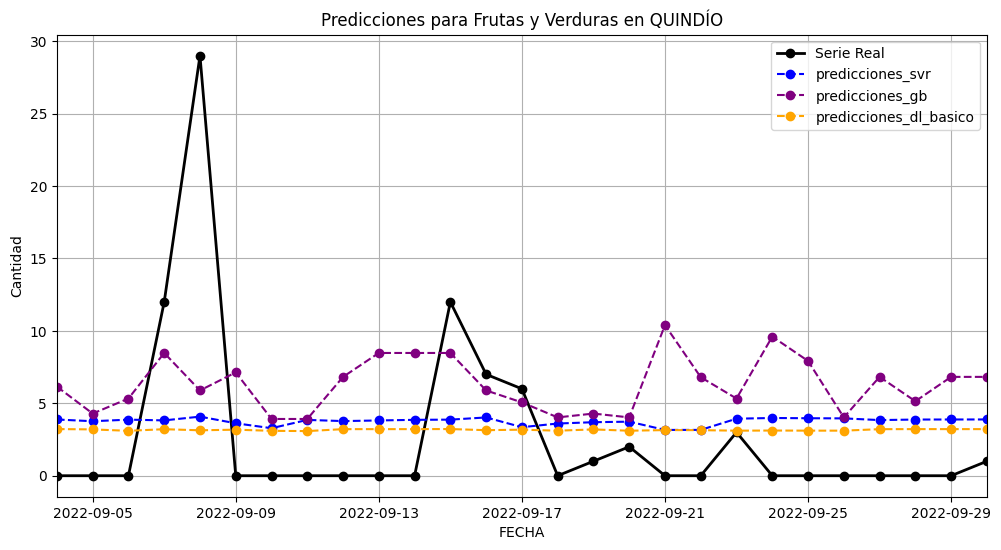

Métricas para Frutas y Verduras en QUINDÍO:
        Dpto        subcategory                 Modelo      RMSE        R2  \
371  QUINDÍO  Frutas y Verduras                    SVR  6.209735 -0.009221   
372  QUINDÍO  Frutas y Verduras             ElasticNet  8.418318 -0.854772   
373  QUINDÍO  Frutas y Verduras          Random Forest  6.933778 -0.258287   
374  QUINDÍO  Frutas y Verduras      Gradient Boosting  7.286338 -0.389500   
375  QUINDÍO  Frutas y Verduras    Red Neuronal Básica  6.197702 -0.005313   
376  QUINDÍO  Frutas y Verduras            LSTM Básica  6.508783 -0.108765   
377  QUINDÍO  Frutas y Verduras  Keras Regresor Básico  6.252289 -0.023100   

     MAPE  
371   NaN  
372   NaN  
373   NaN  
374   NaN  
375   NaN  
376   NaN  
377   NaN  


In [ ]:
# Llama a la función con la subregión y subcategoría deseadas
plot_subregion_subcategory_predictions(df_predicciones, 'QUINDÍO', 'Frutas y Verduras', modelos_a_graficar = ['predicciones_svr', 'predicciones_gb',
                                                                                                              'predicciones_dl_basico'])

In [ ]:
df_modelo.shape

(8865, 52)

In [ ]:
##drop if exists predictions before
cols_to_drop = ['predicciones_svr', 'predicciones_elastic', 'predicciones_rf', 'predicciones_gb',
                'predicciones_dl_basico', 'predicciones_lstm', 'predicciones_kerasR', 'y_prueba']

for col in cols_to_drop:
  if col in df_rellenado.columns:
    df_rellenado = df_rellenado.drop(columns=[col])


##predicciones al dataset completo df_rellenado
X = df_rellenado.drop(columns = ["CANTIDAD", 'FECHA'])
y = df_rellenado['CANTIDAD']

#dummies
X = pd.get_dummies(X, drop_first=1)

# Convertir todas las columnas booleanas a enteros
for col in X.select_dtypes(include='bool').columns:
    X[col] = X[col].astype(int)

##escalar
X[num_vars] = scaler.transform(X[num_vars])
X[num_vars] = X[num_vars].fillna(0)

df_rellenado['predicciones_svr'] = scaler_y.inverse_transform(SVMR_Pol_opt.predict(X).reshape(-1, 1))
df_rellenado['predicciones_elastic'] = scaler_y.inverse_transform(modelElasticNet.predict(X).reshape(-1, 1))
df_rellenado['predicciones_rf'] = scaler_y.inverse_transform(modelRF.predict(X).reshape(-1, 1))
df_rellenado['predicciones_gb'] = scaler_y.inverse_transform(modelGrdB.predict(X).reshape(-1, 1))
df_rellenado['predicciones_dl_basico'] = scaler_y.inverse_transform(model.predict(X).reshape(-1, 1))
df_rellenado['predicciones_lstm'] = scaler_y.inverse_transform(model2.predict(X))
df_rellenado['predicciones_kerasR'] = scaler_y.inverse_transform(keras_model.predict(X))
df_rellenado['y_prueba'] = y


663/663 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
663/663 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step
663/663 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


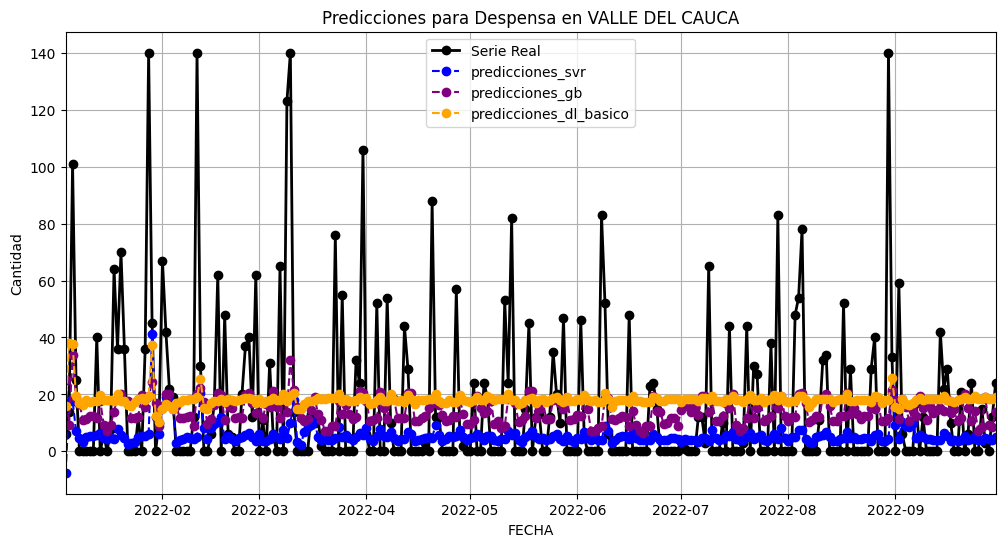

Métricas para Despensa en VALLE DEL CAUCA:
                Dpto subcategory                 Modelo       RMSE        R2  \
308  VALLE DEL CAUCA    Despensa                    SVR  12.440315 -0.177501   
309  VALLE DEL CAUCA    Despensa             ElasticNet  11.470010 -0.000982   
310  VALLE DEL CAUCA    Despensa          Random Forest  11.660365 -0.034482   
311  VALLE DEL CAUCA    Despensa      Gradient Boosting  12.906446 -0.267395   
312  VALLE DEL CAUCA    Despensa    Red Neuronal Básica  14.770028 -0.659821   
313  VALLE DEL CAUCA    Despensa            LSTM Básica  11.475532 -0.001946   
314  VALLE DEL CAUCA    Despensa  Keras Regresor Básico  12.027996 -0.100741   

     MAPE  
308   NaN  
309   NaN  
310   NaN  
311   NaN  
312   NaN  
313   NaN  
314   NaN  


In [ ]:
##visualizar una serie con la funcion construida
cat = "Despensa"
region = "VALLE DEL CAUCA"

plot_subregion_subcategory_predictions(df_rellenado, region, cat, modelos_a_graficar=['predicciones_svr', 'predicciones_gb',
                                                                                                              'predicciones_dl_basico'])

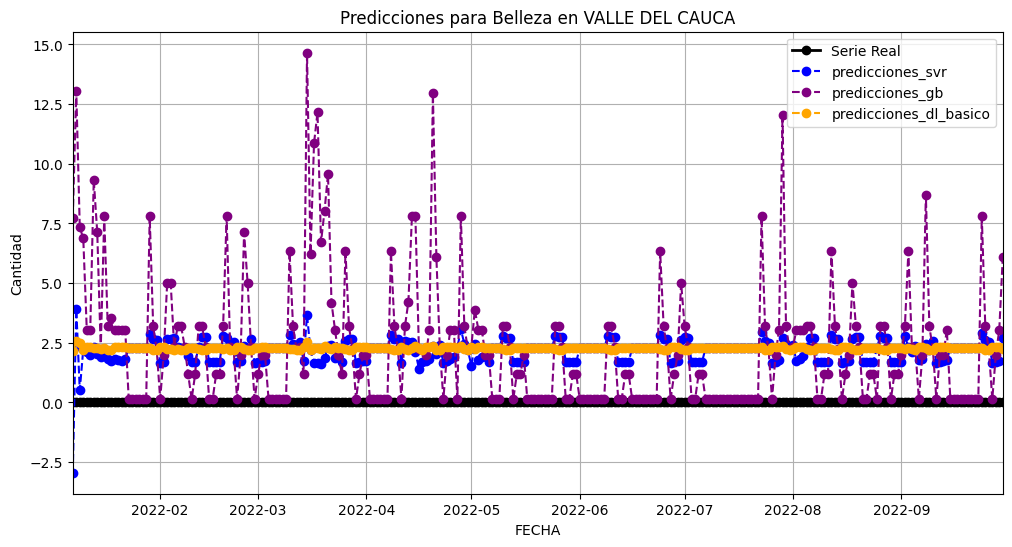

Métricas para Belleza en VALLE DEL CAUCA:
                Dpto subcategory                 Modelo      RMSE   R2  MAPE
329  VALLE DEL CAUCA     Belleza                    SVR  2.200436  0.0   NaN
330  VALLE DEL CAUCA     Belleza             ElasticNet  8.418559  0.0   NaN
331  VALLE DEL CAUCA     Belleza          Random Forest  5.036561  0.0   NaN
332  VALLE DEL CAUCA     Belleza      Gradient Boosting  3.035939  0.0   NaN
333  VALLE DEL CAUCA     Belleza    Red Neuronal Básica  2.267713  0.0   NaN
334  VALLE DEL CAUCA     Belleza            LSTM Básica  1.947954  0.0   NaN
335  VALLE DEL CAUCA     Belleza  Keras Regresor Básico  3.643330  0.0   NaN


In [ ]:
##visualizar una serie con la funcion construida
cat = "Belleza"
region = "VALLE DEL CAUCA"

plot_subregion_subcategory_predictions(df_rellenado, region, cat, modelos_a_graficar=['predicciones_svr', 'predicciones_gb',
                                                                                                              'predicciones_dl_basico'])

In [ ]:
df_metricas

Modelo  RMSE_train      R2_train    MAPE_train  RMSE_test  \
0                   SVMR    6.652433 -10334.489286  1.098078e+16   6.832694   
1        modelElasticNet    8.397338 -16467.473358  2.894428e+16   8.400801   
2          Random Forest   13.887501 -45041.059779  1.951195e+16  14.116525   
3      Gradient Boosting   14.064803 -46198.511726  1.959173e+16  13.613104   
4    Red Neuronal Básica   18.134881 -76805.768527  2.418167e+16  19.248350   
5            LSTM Básica    9.190383 -19724.918642  1.951116e+16   9.383257   
6  Keras Regresor Básico    8.040639 -15098.104245  1.899050e+16   8.271557   

         R2_test     MAPE_test  
0  -14909.361195  1.264024e+16  
1  -22538.571656  2.976988e+16  
2  -63643.350859  2.233861e+16  
3  -59184.945778  2.188338e+16  
4 -118328.021942  2.944930e+16  
5  -28118.754352  2.139088e+16  
6  -21850.377256  2.084159e+16

In [ ]:
df_rellenado[(df_rellenado['Dpto']=='VALLE DEL CAUCA') & (df_rellenado['subcategory']=='Belleza')]["CANTIDAD"].max()

0.0

In [ ]:
##subregion y subcategoria con mas valores diferentes de 0
df_rellenado.loc[df_rellenado['CANTIDAD'] != 0, ['Dpto', 'subcategory']].value_counts().head(3)


Dpto             subcategory      
ANTIOQUIA        Frutas y Verduras    174
VALLE DEL CAUCA  Frutas y Verduras    169
ANTIOQUIA        Pasabocas            153
Name: count, dtype: int64

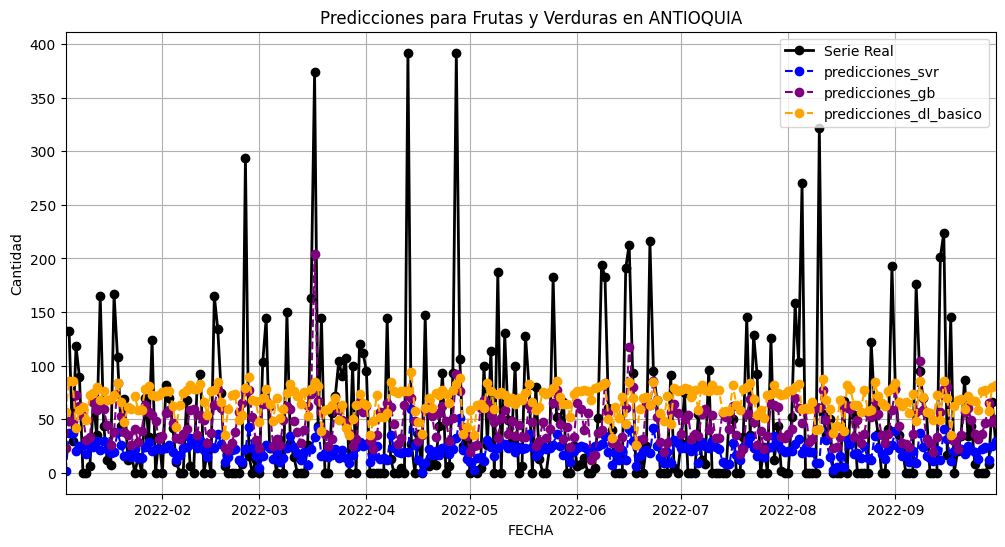

Métricas para Frutas y Verduras en ANTIOQUIA:
         Dpto        subcategory                 Modelo       RMSE        R2  \
28  ANTIOQUIA  Frutas y Verduras                    SVR  70.262591 -0.173756   
29  ANTIOQUIA  Frutas y Verduras             ElasticNet  76.308199 -0.384433   
30  ANTIOQUIA  Frutas y Verduras          Random Forest  55.247451  0.274305   
31  ANTIOQUIA  Frutas y Verduras      Gradient Boosting  57.823008  0.205066   
32  ANTIOQUIA  Frutas y Verduras    Red Neuronal Básica  69.823934 -0.159146   
33  ANTIOQUIA  Frutas y Verduras            LSTM Básica  68.033083 -0.100449   
34  ANTIOQUIA  Frutas y Verduras  Keras Regresor Básico  70.439066 -0.179660   

    MAPE  
28   NaN  
29   NaN  
30   NaN  
31   NaN  
32   NaN  
33   NaN  
34   NaN  


In [ ]:
##visualizar una serie con la funcion construida
cat = "Frutas y Verduras"
region = "ANTIOQUIA"

plot_subregion_subcategory_predictions(df_rellenado, region, cat, modelos_a_graficar=['predicciones_svr', 'predicciones_gb',
                                                                                                              'predicciones_dl_basico'])

# Referencias

- *scikit-learn:*   
    - https://scikit-learn.org/stable/

- *Tensorflow:*   
    - https://www.tensorflow.org/

- *Gráficas con  plotly:*
    - https://plotly.com/python/

- *Compras Dataset:*
    - https://www.kaggle.com/datasets/davidms8/shopping-map
    
- *Lista Productos Con categoria:*
    - https://www.kaggle.com/datasets/camiloemartinez/productos-consumo-masivo

